# Projeto Posicionamento Covid

## 1 - Usando GPU Colaborativo (se disponível)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1.1 - Instalando a biblioteca do Hugging Face

In [2]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.6 MB/s eta 0:00:00


In [3]:
# Ajeitando os pacotes da biblioteca transformers

from transformers import BertForSequenceClassification, BertTokenizer, pipeline

## 2 - Banco de dados

In [4]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

df = pd.read_csv('/content/drive/MyDrive/Projeto Posicionamento COVID/tweets_annotated.csv')


df

,date_post,tweet_id,content,post_vaccine,positions_vac
0,2020-03-19,1240808239224090112,Tenho duas amigas doutorandas na USP. Não estã...,1,1.0
1,2020-03-20,1241121140988410112,"Senado: Promulgado artigo que protege IBGE, Em...",0,NaN
2,2020-03-22,1241825454539120128,ATENÇÃO: programem-se para a vacinação contra ...,0,NaN
3,2020-09-01,1300918558067770112,Chega a ser inacreditável que o governo esteja...,1,1.0
4,2020-10-21,1319042054463290112,"Como prefeito, vamos garantir através da Prefe...",1,1.0
...,...,...,...,...,...
7051,2021-06-28,1409592686840066048,Com os depoimentos dos irmãos Miranda foi dado...,1,2.0
7052,2021-04-30,1388202351996150016,Muitas pessoas estão questionando por que segu...,1,2.0
7053,2021-03-19,1372931201871281920,"Gen Heleno de MÁSCARA, tomando VACINA. Cloroqu...",1,1.0
7054,2021-10-09,1446834442031575040,"As UBS Hélio Macedo, Aygara Motta, Dalmo Feito...",1,1.0


In [5]:
print(df['positions_vac'].dtype,df['content'].dtype)

float64 object


In [6]:

print("Positions_Vac 2020 e 2021:" + "/n", df['positions_vac'].value_counts())

Positions_Vac 2020 e 2021:/n 1.0    3999
2.0    2167
3.0     252
0.0       1
Name: positions_vac, dtype: int64


In [7]:
print(df['content'].dtype)

object


## 2.2 Analisando (parse)

In [8]:
# Extraindo as sentenças e seus valores

# Primeiro, vamos remover posts que não se referem às vacinas

df = df.drop(df[df.post_vaccine == 0].index)

# Agora nosso banco diminuiu mais ainda

print('Número de frases para treinamento: {:,}\n'.format(df.shape[0]))

# Vamos transformar noss variável de positions_vac em int
# Além disso, baseado em Brownlee (2020, p.16), irei assinalar
# a classe majoritária com 0, a intermediária com 1 e a minoritária com 2

def condicao(x):
    if x == 3.0:
        return 1
    elif x == 2.0:
        return 2
    else:
        return 0

df['positions_vac'] = df['positions_vac'].apply(condicao)

# Nos resta, para cada valor, a seguinte distribuição

print(df['positions_vac'].value_counts())

Número de frases para treinamento: 6,420

0    4001
2    2167
1     252
Name: positions_vac, dtype: int64


## Separar um banco só para teste

In [9]:
from torch.utils.data import TensorDataset, random_split, Subset, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split


df_train, df_test = train_test_split(df, test_size = 0.1, stratify = df['positions_vac'], random_state = 42)

print(df_train['positions_vac'].value_counts())
print(df_test['positions_vac'].value_counts())

0    3601
2    1950
1     227
Name: positions_vac, dtype: int64
0    400
2    217
1     25
Name: positions_vac, dtype: int64


In [10]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.utils import shuffle

# Shuffle

df_train2 = shuffle(df_train)


# Iniciar o kfold

skf = StratifiedKFold(n_splits = 5,
                     shuffle = True,
                     random_state = 42)


# Para a estratificação

y = df_train['positions_vac']

# Note:
# Each fold is a tuple ([train_index_values], [val_index_values])
# fold_0, fold_1, fold_2, fold_3, fold_5 = kf.split(df, y)

# Put the folds into a list. This is a list of tuples.

fold_list = list(skf.split(df_train2,y))

train_df_list = []
val_df_list = []

for i, fold in enumerate(fold_list):

  # Map the train and val index values to dataframe rows
  df_train2 = df[df.index.isin(fold[0])]
  df_val = df[df.index.isin(fold[1])]

  train_df_list.append(df_train2)
  val_df_list.append(df_val)



print(len(train_df_list))
print(len(val_df_list))

5
5


In [11]:
target = df_train.loc[:,'positions_vac']


fold_no = 1
for train_index, test_index in skf.split(df_train, target):
  train = df_train.iloc[train_index,:]
  test = df_train.iloc[test_index,:]
  print('Train in Fold',str(fold_no), train['positions_vac'].value_counts())
  print('Test in Fold',str(fold_no), test['positions_vac'].value_counts())
  fold_no += 1

Train in Fold 1 0    2880
2    1560
1     182
Name: positions_vac, dtype: int64
Test in Fold 1 0    721
2    390
1     45
Name: positions_vac, dtype: int64
Train in Fold 2 0    2881
2    1560
1     181
Name: positions_vac, dtype: int64
Test in Fold 2 0    720
2    390
1     46
Name: positions_vac, dtype: int64
Train in Fold 3 0    2881
2    1560
1     181
Name: positions_vac, dtype: int64
Test in Fold 3 0    720
2    390
1     46
Name: positions_vac, dtype: int64
Train in Fold 4 0    2881
2    1560
1     182
Name: positions_vac, dtype: int64
Test in Fold 4 0    720
2    390
1     45
Name: positions_vac, dtype: int64
Train in Fold 5 0    2881
2    1560
1     182
Name: positions_vac, dtype: int64
Test in Fold 5 0    720
2    390
1     45
Name: positions_vac, dtype: int64


## Treinando o Modelo BERT


### Configs

In [ ]:

import os

MODEL_TYPE = 'neuralmind/bert-base-portuguese-cased'

NUM_FOLDS = 5

# Saving 5 TPU models will exceed the 4.9GB disk space.
# Therefore, will will only train on 3 folds.

NUM_FOLDS_TO_TRAIN = 5


L_RATE = 2e-5
MAX_LEN = 256
NUM_EPOCHS = 5
BATCH_SIZE = 32
NUM_CORES = os.cpu_count()

NUM_CORES

2

In [ ]:
import torch

# Se houver uma GPU
if torch.cuda.is_available():

    # Use o GPU
    device = torch.device("cuda")

    print("Existem %d GPU(s) disponíveis.") # torch.cuda.device_cour

    print("We will use the GPU:", torch.cuda.get_device_name(0))

# Se não

else:
    print("Não há uma GPU disponível, utilizando a CPU")
    device = torch.device("cpu")

Existem %d GPU(s) disponíveis.
We will use the GPU: Tesla T4


### Instanciando o Tokenizador

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained(MODEL_TYPE, do_lower_case=True)

Loading BERT tokenizer...


### Criando o Data Loader


In [ ]:
from torch.utils.data import Dataset, DataLoader



class CompDataset(Dataset):

  def __init__(self, df):
    self.df_data = df


  def __getitem__(self, index):

    # Pegar as sentenças do dataframe
    sentence = self.df_data.loc[index, 'content']


    # Processar a sentença

    encoded_dict = tokenizer.encode_plus(sentence,  # Sentenças para serem tokenizadas
                                         add_special_tokens = True, # Adicionar [CLS] e [SEP]
                                         padding = 'max_length',
                                         max_length = MAX_LEN,
                                         return_attention_mask = True, # Construir attn. masks.
                                         return_tensors = 'pt', # Retornar os tensores do pytorch
                                        )


    # Esses já são tensores do torch

    padded_token_list = encoded_dict['input_ids'][0]
    att_mask = encoded_dict['attention_mask'][0]
    token_type_ids = encoded_dict['token_type_ids'][0]


    # Transformar o position_vac (target) em um tensor

    target = torch.tensor(self.df_data.loc[index, 'positions_vac'])

    sample = (padded_token_list, att_mask, token_type_ids, target)

    return sample


  def __len__(self):

    return len(self.df_data)




class TestDataset(Dataset):

  def __init__(self, df):
    self.df_data = df


  def __getitem__(self, index):

    # Pegar as sentenças do dataframe
    sentence = self.df_data.iloc[index, self.df_data.columns.get_loc('content')]


    # Processar a sentença

    encoded_dict = tokenizer.encode_plus(sentence,  # Sentenças para serem tokenizadas
                                         add_special_tokens = True, # Adicionar [CLS] e [SEP]
                                         padding = 'max_length',
                                         max_length = MAX_LEN,
                                         return_attention_mask = True, # Construir attn. masks.
                                         return_tensors = 'pt', # Retornar os tensores do pytorch
                                        )


    # Esses já são tensores do torch

    padded_token_list = encoded_dict['input_ids'][0]
    att_mask = encoded_dict['attention_mask'][0]
    token_type_ids = encoded_dict['token_type_ids'][0]


    # Transformar o position_vac (target) em um tensor

    target = torch.tensor(self.df_data.iloc[index, self.df_data.columns.get_loc('positions_vac')])

    sample = (padded_token_list, att_mask, token_type_ids, target)

    return sample


  def __len__(self):

    return len(self.df_data)




### Testando o Dataloader

In [ ]:
df_train2, df_val2 = train_test_split(df, test_size = 0.2, stratify = df['positions_vac'], random_state = 42)


df_train2 = df_train.reset_index(drop=True)
df_val2 = df_val.reset_index(drop = True)


print('Tamanho do banco de treino: ', len(df_train2))
print(df_train2['positions_vac'].value_counts())
print('Tamanho do banco de validação: ', len(df_val2))
print(df_val2['positions_vac'].value_counts())



Tamanho do banco de treino:  5777
0    3600
2    1950
1     227
Name: positions_vac, dtype: int64
Tamanho do banco de validação:  1032
0    657
2    327
1     48
Name: positions_vac, dtype: int64


In [ ]:
train_data = CompDataset(df_train2)
val_data = CompDataset(df_val2)
test_data = TestDataset(df_test)

train_dataloader = torch.utils.data.DataLoader(train_data,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True)

val_dataloader = torch.utils.data.DataLoader(val_data,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True)

test_dataloader = torch.utils.data.DataLoader(test_data,
                                        batch_size=BATCH_SIZE,
                                        shuffle=False)



print(len(train_dataloader))
print(len(val_dataloader))
print(len(test_dataloader))

181
33
21


In [ ]:
# Get one train batch

padded_token_list, att_mask, token_type_ids, target = next(iter(train_dataloader))

print(padded_token_list.shape)
print(att_mask.shape)
print(token_type_ids.shape)
print(target.shape)

torch.Size([32, 256])
torch.Size([32, 256])
torch.Size([32, 256])
torch.Size([32])


In [ ]:
# Get one val batch

padded_token_list, att_mask, token_type_ids, target = next(iter(val_dataloader))

print(padded_token_list.shape)
print(att_mask.shape)
print(token_type_ids.shape)
print(target.shape)

torch.Size([32, 256])
torch.Size([32, 256])
torch.Size([32, 256])
torch.Size([32])


In [ ]:
# Get one test batch


padded_token_list, att_mask, token_type_ids, target = next(iter(test_dataloader))

print(padded_token_list.shape)
print(att_mask.shape)
print(token_type_ids.shape)
print(target.shape)

torch.Size([32, 256])
torch.Size([32, 256])
torch.Size([32, 256])
torch.Size([32])


### Definindo o modelo

In [ ]:
# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    MODEL_TYPE,
    num_labels = 3,
    output_attentions = False)

# Send the model to the device.
model.to(device)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

### Testando o modelo

In [ ]:
# Get one train batch

train_dataloader = torch.utils.data.DataLoader(train_data,
                                        batch_size=8,
                                        shuffle=True,
                                       num_workers=NUM_CORES)

batch = next(iter(train_dataloader))

b_input_ids = batch[0].to(device)
b_input_mask = batch[1].to(device)
b_token_type_ids = batch[2].to(device)
b_labels = batch[3].to(device)



In [ ]:
outputs = model(b_input_ids,
                token_type_ids=b_token_type_ids,
                attention_mask=b_input_mask,
                labels=b_labels)

In [ ]:
outputs

SequenceClassifierOutput(loss=tensor(1.1057, device='cuda:0', grad_fn=<NllLossBackward0>), logits=tensor([[-0.1316,  0.0683, -0.1486],
        [-0.0156,  0.1492, -0.2001],
        [-0.1561,  0.0442, -0.2240],
        [-0.0740,  0.0832, -0.2665],
        [-0.1421,  0.1042, -0.1621],
        [-0.0909,  0.0504, -0.2320],
        [-0.0458,  0.0774, -0.1636],
        [-0.0130,  0.1693, -0.1370]], device='cuda:0',
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [ ]:
# Predictions

outputs[1]

tensor([[-0.1316,  0.0683, -0.1486],
        [-0.0156,  0.1492, -0.2001],
        [-0.1561,  0.0442, -0.2240],
        [-0.0740,  0.0832, -0.2665],
        [-0.1421,  0.1042, -0.1621],
        [-0.0909,  0.0504, -0.2320],
        [-0.0458,  0.0774, -0.1636],
        [-0.0130,  0.1693, -0.1370]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [ ]:
preds = outputs[1].detach().cpu().numpy()

y_true = b_labels.detach().cpu().numpy()
y_pred = np.argmax(preds, axis = 1)

y_pred

array([1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score


# This is the accuracy without any fine tuning.

val_acc = accuracy_score(y_true, y_pred)

val_acc

0.25

In [ ]:
# Métricas

from sklearn.metrics import accuracy_score, f1_score, classification_report

# Função para calcular a accuracy de nossas predições vs. labels

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis = 1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Classification report
def classification_report_with_accuracy_score(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    # labels_flat = labels.flatten()
    report = classification_report(labels, pred_flat, output_dict = True, zero_division = 0)
    df_class_report = pd.DataFrame(report).transpose()
    return df_class_report

In [ ]:
from collections import Counter
import torch.utils.data as data
import random

# Set a seed value.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

NUM_FOLDS_TO_TRAIN = 5
NUM_FOLDS = 5

skf = StratifiedKFold(n_splits = 5,
                     shuffle = True,
                     random_state = 42)

train_y_list = []


for fold_index, (train_index, val_index) in enumerate(skf.split(df_train,y)):

  print("\nNum folds used for training:", NUM_FOLDS_TO_TRAIN)
  print('\n============== Modelo do Fold', fold_index)

  train = df_train.iloc[train_index,:]
  val = df_train.iloc[val_index,:]

  train = train.reset_index(drop=True)
  val = val.reset_index(drop=True)

  # Checando se a distribuição dos bancos está proporcional para as classes
  print('Fold: ', fold_index, "/n Tamanho do banco de treino: ", len(train))
  print(train['positions_vac'].value_counts())
  print('Fold: ', fold_index, '/n Tamanho do banco de validação: ', len(val))
  print(val['positions_vac'].value_counts())

  # Criando os dataloaders
  train_data = CompDataset(train)
  val_data = CompDataset(val)

  train_dataloader = torch.utils.data.DataLoader(train_data,
                                                   batch_size=BATCH_SIZE,
                                                   shuffle=True,
                                                   num_workers=NUM_CORES)

  val_dataloader = torch.utils.data.DataLoader(val_data,
                                                 batch_size=BATCH_SIZE,
                                                 shuffle=True,
                                                 num_workers=NUM_CORES)

  # Pegar o número de folds
  num_folds = len(train_df_list)

# Para cada epoch...

  print('----------------------')

  for epoch in range(0, NUM_EPOCHS):

    print('Distribuição das classes (Treino) - Epoch:', epoch)

    train_targets_list = []

    for idx, batch in enumerate(train_dataloader):

      b_labels = batch[3].to(device)

      # Move the labels to the cpu
      targets_np = b_labels.to('cpu').numpy()

      # Append the labels to a numpy list
      train_targets_list.extend(targets_np)


    print(Counter(train_targets_list))

    print('Distribuição das classes (Validação) - Epoch:', epoch)

    val_targets_list = []

    for idx, batch in enumerate(val_dataloader):

      b_labels = batch[3].to(device)

      # Move the labels to the cpu
      targets_np = b_labels.to('cpu').numpy()

      # Append the labels to a numpy list
      val_targets_list.extend(targets_np)


    print(Counter(val_targets_list))


Num folds used for training: 5

============== Modelo do Fold 0
Fold:  0 /n Tamanho do banco de treino:  4621
0    2880
2    1560
1     181
Name: positions_vac, dtype: int64
Fold:  0 /n Tamanho do banco de validação:  1156
0    720
2    390
1     46
Name: positions_vac, dtype: int64
----------------------
Distribuição das classes (Treino) - Epoch: 0
Counter({0: 2880, 2: 1560, 1: 181})
Distribuição das classes (Validação) - Epoch: 0
Counter({0: 720, 2: 390, 1: 46})
Distribuição das classes (Treino) - Epoch: 1
Counter({0: 2880, 2: 1560, 1: 181})
Distribuição das classes (Validação) - Epoch: 1
Counter({0: 720, 2: 390, 1: 46})
Distribuição das classes (Treino) - Epoch: 2
Counter({0: 2880, 2: 1560, 1: 181})
Distribuição das classes (Validação) - Epoch: 2
Counter({0: 720, 2: 390, 1: 46})
Distribuição das classes (Treino) - Epoch: 3
Counter({0: 2880, 2: 1560, 1: 181})
Distribuição das classes (Validação) - Epoch: 3
Counter({0: 720, 2: 390, 1: 46})
Distribuição das classes (Treino) - Epoch: 4

### Treinando o modelo

In [ ]:
%%time

from transformers import AdamW
import random
import gc

# Para remover o warning

from transformers import logging

logging.set_verbosity_warning()



# Set a seed value.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

NUM_FOLDS_TO_TRAIN = 5
NUM_FOLDS = 5

skf = StratifiedKFold(n_splits = 5,
                     shuffle = True,
                     random_state = 42)



# Store the accuracy scores for each fold model in this list.
# [[model_0 scores], [model_1 scores], [model_2 scores], [model_3 scores], [model_4 scores]]
# [[ecpoch 1, epoch 2, ...], [ecpoch 1, epoch 2, ...], [ecpoch 1, epoch 2, ...], [ecpoch 1, epoch 2, ...], [ecpoch 1, epoch 2, ...]]

# Create a list of lists to store the val acc results.
# The number of items in this list will correspond to
# the number of folds that the model is being trained on.

fold_val_acc_list = []
fold_val_f1macro_list = []


# Guardando algumas quantidades como treino, validation loss,
# validation accuracy, and timings.

training_stats = []
clf_report = pd.DataFrame()


for i in range(0, NUM_FOLDS):

    # append an empty list
    fold_val_acc_list.append([])
    fold_val_f1macro_list.append([])



for fold_index, (train_index, val_index) in enumerate(skf.split(df_train,y)):

  print("\nNum folds used for training:", NUM_FOLDS_TO_TRAIN)
  print('\n################## Modelo do Fold', fold_index, '##################')

  # .....................................
  # Definindo os dataloaders de treino e validação
  # .....................................


  # Pegando os dados de treino e validação
  train = df_train.iloc[train_index,:]
  val = df_train.iloc[val_index,:]


  # Resetar os indíces para funcionar
  train_res = train.reset_index(drop = True)
  val_res = val.reset_index(drop = True)


  # Checando se a distribuição dos bancos está proporcional para as classes
  print('Fold: ', fold_index, "\n Tamanho do banco de treino: ", len(train_res))
  print(train_res['positions_vac'].value_counts())
  print('Fold: ', fold_index, '\n Tamanho do banco de validação: ', len(val_res))
  print(val_res['positions_vac'].value_counts())

  # Tokenizando e transformando em inputs (att masks, labels, etc.)
  train_data = CompDataset(train_res)
  val_data = CompDataset(val_res)

  # Criando o dataloader
  train_dataloader = torch.utils.data.DataLoader(train_data,
                                                   batch_size=BATCH_SIZE,
                                                   shuffle=True,
                                                   num_workers=NUM_CORES)

  val_dataloader = torch.utils.data.DataLoader(val_data,
                                                 batch_size=BATCH_SIZE,
                                                 shuffle=False,
                                                 num_workers=NUM_CORES)

  # Pegar o número de folds
  num_folds = len(train_df_list)

# Para cada epoch...

  for epoch in range(0, NUM_EPOCHS):

    #......................
    # Carregar o modelo do fold
    #......................

    if epoch == 0:

      # Definir o modelo
      model = BertForSequenceClassification.from_pretrained(
          MODEL_TYPE,
          num_labels = 3,
          output_attentions = False,
          output_hidden_states = False,
          )

      # Send the model to the device.

      model.to(device)

      optimizer = AdamW(model.parameters(),
                        lr = L_RATE,
                        eps = 1e-8
                        )

    else:

      # Pegar o modelo do fold
      path_model = 'model_' + str(fold_index) + '.bin'

      if os.path.exists(path_model):
        model.load_state_dict(torch.load(path_model))

      else:
        print(f"Error: {path_model} does not exist")

      # enviar o modelo para o device.
        model.to(device)


    print('============== Epoch {:} / {:} =============='.format(epoch + 1, NUM_EPOCHS))

    # For this epoch, store the val acc scores for each fold in this list.
    # We will use this list to calculate the cv at the end of the epoch.
    epoch_acc_scores_list = []

    # ========================================
    #               Treinamento
    # ========================================

    stacked_val_labels = []
    targets_list = []

    print('Treinando...')

    # put the model into train mode
    model.train()

    # This turns gradient calculations on and off.
    torch.set_grad_enabled(True)


    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Tracking variables
    total_f1_score = 0
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0


    for i, batch in enumerate(train_dataloader):

      train_status = 'Batch ' + str(i+1) + ' of ' + str(len(train_dataloader))

      print(train_status, end='\r')


      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_token_type_ids = batch[2].to(device)
      b_labels = batch[3].to(device)

      model.zero_grad()


      loss, logits = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask,
                           return_dict = False,
                           labels=b_labels)

      # Convert the loss from a torch tensor to a number.
      # Calculate the total loss.
      total_train_loss = total_train_loss + loss.item()

      # Zero the gradients
      optimizer.zero_grad()

      # Perform a backward pass to calculate the gradients.
      loss.backward()

      # Clip the norm of the gradients to 1.0.
      # This is to help prevent the "exploding gradients" problem.
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      # Use the optimizer to update Weights

      # Optimizer for GPU
      optimizer.step()

      # Optimizer for TPU
      # https://pytorch.org/xla/
      #xm.optimizer_step(optimizer, barrier=True)


    avg_train_loss = total_train_loss / len(train_dataloader)

    print('Total Train loss:' ,total_train_loss)
    print('Average Train Loss: ', avg_train_loss)


    # ========================================
    #               Validação
    # ========================================
    print('=============================================')
    print('\nValidação...')

    # Put the model in evaluation mode.
    model.eval()

    # Turn off the gradient calculations.
    # This tells the model not to compute or store gradients.
    # This step saves memory and speeds up validation.
    torch.set_grad_enabled(False)


    # Reset the total loss for this epoch.
    total_val_loss = 0

    # Tracking variables
    total_f1_score = 0
    total_weig_f1 = 0
    total_macro_f1 = 0
    total_eval_accuracy = 0
    total_eval_loss = 0


    for j, val_batch in enumerate(val_dataloader):

      val_status = 'Batch ' + str(j+1) + ' of ' + str(len(val_dataloader))

      print(val_status, end='\r')

      b_input_ids = val_batch[0].to(device)
      b_input_mask = val_batch[1].to(device)
      b_token_type_ids = val_batch[2].to(device)
      b_labels = val_batch[3].to(device)


      loss, logits = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask,
                           return_dict = False,
                           labels=b_labels)

      # Convert the loss from a torch tensor to a number.
      # Calculate the total loss.
      total_val_loss = total_val_loss + loss.item()


      # Move preds to the CPU
      val_preds = logits.detach().cpu().numpy()

      # Move the labels to the cpu
      targets_np = b_labels.to('cpu').numpy()

      # Append the labels to a numpy list
      targets_list.extend(targets_np)

      if j == 0: # Para o primeiro batch
        stacked_val_preds = val_preds

      else:
        stacked_val_preds = np.vstack((stacked_val_preds, val_preds))


      # Calculate the accuracy for this batch of test sentences, and
      # accumulate it over all batches. '
      total_eval_accuracy += flat_accuracy(val_preds, targets_np)
      total_f1_score += f1_score(np.argmax(val_preds,axis=1),
                                 targets_np,
                                 average = 'micro')

      total_weig_f1 += f1_score(np.argmax(val_preds, axis = 1),
                                  targets_np,
                                  average = 'weighted')


      total_macro_f1 += f1_score(np.argmax(val_preds, axis = 1),
                                  targets_np,
                                  average = 'macro')



    # .........................................
    # Calculate the validation accuracy for this fold
    # .........................................


    # Calculate the validation accuracy
    y_true = targets_list
    y_pred = np.argmax(stacked_val_preds, axis=1)


    # Metrica do Sklearn
    val_acc = accuracy_score(y_true, y_pred)

    # Flat Accuracy
    avg_val_accuracy = total_eval_accuracy / len(val_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # F1-score (Micro)
    avg_f1_score = total_f1_score / len(val_dataloader)
    print("  F1_score: {0:.2f}".format(avg_f1_score))

    # Macro F1
    avg_macro_f1 = total_macro_f1 / len(val_dataloader)
    print(" Macro F1-score: {0:.2f}".format(avg_macro_f1))

    # Weighted F1
    avg_weig_f1 = total_weig_f1 / len(val_dataloader)
    print(" Weighted F1-score: {0:.2f}".format(avg_weig_f1))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_val_loss / len(val_dataloader)


    # Class_report

    class_report = classification_report_with_accuracy_score(stacked_val_preds, y_true)

    # epoch_acc_scores_list.append(val_acc)
    epoch_acc_scores_list.append(avg_macro_f1)


    print('Val. loss:' ,total_val_loss)
    print('Val. acc: ', val_acc)
    print('Val. F1_Score', avg_f1_score)
    print('Classification Report: \n', class_report)


    training_stats.append(
        {
            'epoch': epoch + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'f1_score_micro' : avg_f1_score,
            'macro_f1_score' : avg_macro_f1,
            'weighted_f1_score': avg_weig_f1,
            'classification_report':class_report,
            'fold' : fold_index

        }
      )


    classif_report = pd.DataFrame({'epoch': epoch + 1,
                                    'fold': fold_index,
                                    'class_report': [class_report]})


    # .........................
    # Save the best model
    # .........................

    if epoch == 0:

      # Save the Model
      model_name = 'model_' + str(fold_index) + '.bin'
      torch.save(model.state_dict(), model_name)
      print('Saved model as ', model_name)

    if epoch != 0:

      val_acc_list = fold_val_acc_list[fold_index]
      val_f1macro_list = fold_val_f1macro_list[fold_index]

      best_val_f1macro = max(val_f1macro_list)
      best_val_acc = max(val_acc_list)


      if avg_macro_f1 > best_val_f1macro:

        model_name = 'model_' + str(fold_index) + '.bin'
        torch.save(model.state_dict(), model_name)
        print('F1-Macro improved. Saved model as ', model_name)

      #if val_acc > best_val_acc:
        #model_name = 'model_' + str(fold_index) + '.bin'
        #torch.save(model.state_dict(), model_name)
        #print('Val acc improved. Saved model as ', model_name)



    # .....................................
    # Save the val_acc for this fold model
    # .....................................

    # Note: Don't do this before the above 'Save Model' code or
    # the save model code won't work. This is because the best_val_acc will
    # become current val accuracy.

    # fold_val_acc_list is a list of lists.
    # Each fold model has it's own list corresponding to the fold index.
    # Here we choose a list corresponding to the fold number and append the acc score to that list.
    fold_val_acc_list[fold_index].append(val_acc)
    fold_val_f1macro_list[fold_index].append(avg_macro_f1)




    # Use the garbage collector to save memory.
    gc.collect()



# .............................................................
# Calculate the CV accuracy score over all folds in this epoch
# .............................................................


# Print the average val accuracy for all 5 folds
cv_f1macro = sum(epoch_acc_scores_list)/NUM_FOLDS_TO_TRAIN
print("\nCross Validation F1-Macro:", cv_f1macro)


Num folds used for training: 5

################## Modelo do Fold 0 ##################
Fold:  0 
 Tamanho do banco de treino:  4621
0    2880
2    1560
1     181
Name: positions_vac, dtype: int64
Fold:  0 
 Tamanho do banco de validação:  1156
0    720
2    390
1     46
Name: positions_vac, dtype: int64


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

============== Epoch 1 / 5 ==============
Treinando...


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Total Train loss: 92.59864327311516
Average Train Loss:  0.6386113329180356

Validação...
  Accuracy: 0.77
  F1_score: 0.77
 Macro F1-score: 0.57
 Weighted F1-score: 0.78
Val. loss: 20.627488881349564
Val. acc:  0.7612456747404844
Val. F1_Score 0.7668918918918919
Classification Report: 
               precision    recall  f1-score      support
0              0.777916  0.870833  0.821756   720.000000
1              0.000000  0.000000  0.000000    46.000000
2              0.722857  0.648718  0.683784   390.000000
accuracy       0.761246  0.761246  0.761246     0.761246
macro avg      0.500258  0.506517  0.501847  1156.000000
weighted avg   0.728385  0.761246  0.742509  1156.000000
Saved model as  model_0.bin
============== Epoch 2 / 5 ==============
Treinando...
Total Train loss: 63.75424610078335
Average Train Loss:  0.43968445586747135

Validação...
  Accuracy: 0.79
  F1_score: 0.79
 Macro F1-score: 0.68
 Weighted F1-score: 0.80
Val. loss: 19.41253637522459
Val. acc:  0.781141868512110

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

============== Epoch 1 / 5 ==============
Treinando...


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Total Train loss: 93.60383549332619
Average Train Loss:  0.645543693057422

Validação...
  Accuracy: 0.79
  F1_score: 0.79
 Macro F1-score: 0.63
 Weighted F1-score: 0.81
Val. loss: 19.50158268213272
Val. acc:  0.7958477508650519
Val. F1_Score 0.7947635135135135
Classification Report: 
               precision    recall  f1-score      support
0              0.818418  0.876389  0.846412   720.000000
1              0.833333  0.108696  0.192308    46.000000
2              0.749340  0.728205  0.738622   390.000000
accuracy       0.795848  0.795848  0.795848     0.795848
macro avg      0.800364  0.571097  0.592447  1156.000000
weighted avg   0.795707  0.795848  0.784018  1156.000000
Saved model as  model_1.bin
============== Epoch 2 / 5 ==============
Treinando...
Total Train loss: 65.60727195441723
Average Train Loss:  0.45246394451322225

Validação...
  Accuracy: 0.78
  F1_score: 0.78
 Macro F1-score: 0.65
 Weighted F1-score: 0.79
Val. loss: 19.560978144407272
Val. acc:  0.7837370242214533

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

============== Epoch 1 / 5 ==============
Treinando...


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Total Train loss: 96.98800119757652
Average Train Loss:  0.668882766879838

Validação...
  Accuracy: 0.78
  F1_score: 0.78
 Macro F1-score: 0.58
 Weighted F1-score: 0.79
Val. loss: 20.329388111829758
Val. acc:  0.7792207792207793
Val. F1_Score 0.776463963963964
Classification Report: 
               precision    recall  f1-score      support
0              0.799496  0.880556  0.838070   720.000000
1              0.000000  0.000000  0.000000    45.000000
2              0.734807  0.682051  0.707447   390.000000
accuracy       0.779221  0.779221  0.779221     0.779221
macro avg      0.511434  0.520869  0.515172  1155.000000
weighted avg   0.746503  0.779221  0.761311  1155.000000
Saved model as  model_2.bin
============== Epoch 2 / 5 ==============
Treinando...
Total Train loss: 68.23494713008404
Average Train Loss:  0.4705858422764416

Validação...
  Accuracy: 0.79
  F1_score: 0.79
 Macro F1-score: 0.68
 Weighted F1-score: 0.80
Val. loss: 19.101731419563293
Val. acc:  0.793939393939394
V

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

============== Epoch 1 / 5 ==============
Treinando...


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Total Train loss: 96.29423147439957
Average Train Loss:  0.6640981480993073

Validação...
  Accuracy: 0.78
  F1_score: 0.78
 Macro F1-score: 0.59
 Weighted F1-score: 0.80
Val. loss: 20.12129954993725
Val. acc:  0.7731601731601732
Val. F1_Score 0.7787162162162162
Classification Report: 
               precision    recall  f1-score     support
0              0.784920  0.881944  0.830608   720.00000
1              0.000000  0.000000  0.000000    45.00000
2              0.745665  0.661538  0.701087   390.00000
accuracy       0.773160  0.773160  0.773160     0.77316
macro avg      0.510195  0.514494  0.510565  1155.00000
weighted avg   0.741083  0.773160  0.754512  1155.00000
Saved model as  model_3.bin
============== Epoch 2 / 5 ==============
Treinando...
Total Train loss: 67.33215907216072
Average Train Loss:  0.46435971773903945

Validação...
  Accuracy: 0.79
  F1_score: 0.79
 Macro F1-score: 0.65
 Weighted F1-score: 0.81
Val. loss: 19.477808132767677
Val. acc:  0.7878787878787878
Val. 

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

============== Epoch 1 / 5 ==============
Treinando...


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Total Train loss: 95.75392070412636
Average Train Loss:  0.6603718669250094

Validação...
  Accuracy: 0.80
  F1_score: 0.80
 Macro F1-score: 0.63
 Weighted F1-score: 0.81
Val. loss: 19.119265541434288
Val. acc:  0.7913419913419913
Val. F1_Score 0.7964527027027027
Classification Report: 
               precision    recall  f1-score      support
0              0.818898  0.866667  0.842105   720.000000
1              1.000000  0.044444  0.085106    45.000000
2              0.736573  0.738462  0.737516   390.000000
accuracy       0.791342  0.791342  0.791342     0.791342
macro avg      0.851824  0.549858  0.554909  1155.000000
weighted avg   0.798156  0.791342  0.777296  1155.000000
Saved model as  model_4.bin
============== Epoch 2 / 5 ==============
Treinando...
Total Train loss: 67.25379081070423
Average Train Loss:  0.463819246970374

Validação...
  Accuracy: 0.81
  F1_score: 0.81
 Macro F1-score: 0.69
 Weighted F1-score: 0.82
Val. loss: 17.70522752404213
Val. acc:  0.8008658008658008


### Make a prediction on the test set

In [ ]:
# ========================================
#               Test Set
# ========================================

print('\nTest Set...')

model_preds_list = []

print('Total batches:', len(test_dataloader))

for fold_index in range(0, NUM_FOLDS_TO_TRAIN):

    print('\nFold Model', fold_index)

    # Load the fold model
    path_model = 'model_' + str(fold_index) + '.bin'
    model.load_state_dict(torch.load(path_model))

    # Send the model to the device.
    model.to(device)


    stacked_val_labels = []


    # Put the model in evaluation mode.
    model.eval()

    # Turn off the gradient calculations.
    # This tells the model not to compute or store gradients.
    # This step saves memory and speeds up validation.
    torch.set_grad_enabled(False)


    # Reset the total loss for this epoch.
    total_val_loss = 0

    for j, h_batch in enumerate(test_dataloader):

        inference_status = 'Batch ' + str(j + 1)

        print(inference_status, end='\r')

        b_input_ids = h_batch[0].to(device)
        b_input_mask = h_batch[1].to(device)
        b_token_type_ids = h_batch[2].to(device)


        outputs = model(b_input_ids,
                token_type_ids=b_token_type_ids,
                attention_mask=b_input_mask)


        # Get the preds
        preds = outputs[0]


        # Move preds to the CPU
        val_preds = preds.detach().cpu().numpy()


        # Stack the predictions.

        if j == 0:  # first batch
            stacked_val_preds = val_preds

        else:
            stacked_val_preds = np.vstack((stacked_val_preds, val_preds))


    model_preds_list.append(stacked_val_preds)


print('\nPrediction complete.')


Test Set...
Total batches: 21

Fold Model 0
Batch 21
Fold Model 1
Batch 21
Fold Model 2
Batch 21
Fold Model 3
Batch 21
Fold Model 4
Batch 21
Prediction complete.


In [ ]:
model_preds_list

[array([[ 1.2753975 , -2.7404177 ,  1.5412877 ],
        [ 1.4834626 , -2.943304  ,  1.6770753 ],
        [ 0.12976208, -0.7245738 ,  0.45755282],
        ...,
        [ 1.9111578 , -3.221701  ,  1.5063165 ],
        [-0.7860269 , -0.02123638,  0.6432648 ],
        [ 0.41602734, -3.261719  ,  2.741869  ]], dtype=float32),
 array([[-0.03517103, -2.4334514 ,  2.098933  ],
        [ 2.8714151 , -3.2652035 , -0.31837773],
        [-1.0842603 , -0.6127457 ,  1.7909755 ],
        ...,
        [ 1.6495588 , -3.5933    ,  1.3052739 ],
        [-1.4677739 ,  1.890107  ,  0.01542807],
        [ 0.20985408, -3.4813764 ,  2.9498906 ]], dtype=float32),
 array([[-0.2884542 , -1.5782075 ,  1.8652769 ],
        [ 1.3625729 , -3.1666703 ,  1.3904836 ],
        [ 1.0182753 , -0.44964218, -0.53679925],
        ...,
        [ 2.9526937 , -3.0086868 ,  0.22413705],
        [ 0.8335106 ,  0.05278349, -0.68298626],
        [ 1.6269947 , -3.6602848 ,  2.0501158 ]], dtype=float32),
 array([[-0.8084492 , -2.205

In [ ]:
# Take the argmax. This returns the column index of the max value in each row.

# Sum the predictions of all fold models
for i, item in enumerate(model_preds_list):

    if i == 0:

        preds = item

    else:

        # Sum the matrices
        preds = item + preds


# Average the predictions
avg_preds = preds/(len(model_preds_list))


test_preds = np.argmax(avg_preds, axis=1)

In [ ]:
accuracy_score(df_test['positions_vac'], test_preds)

0.7959501557632399

In [ ]:
print(classification_report(df_test['positions_vac'], test_preds, labels = [0,1,2]))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84       400
           1       0.70      0.64      0.67        25
           2       0.73      0.71      0.72       217

    accuracy                           0.80       642
   macro avg       0.75      0.73      0.74       642
weighted avg       0.79      0.80      0.80       642



In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy


confusion_matrix = metrics.confusion_matrix(df_test['positions_vac'], test_preds)

confusion_matrix

array([[341,   5,  54],
       [  7,  16,   2],
       [ 61,   2, 154]])

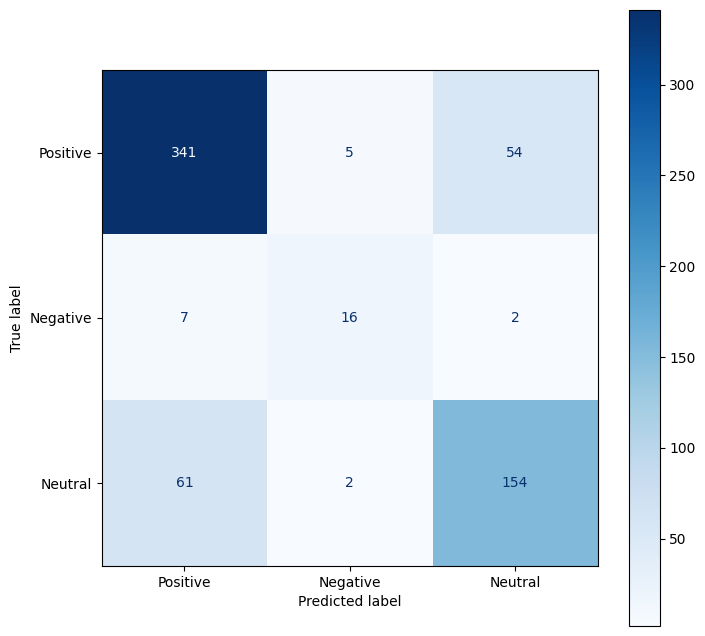

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_predictions(
                  df_test['positions_vac'],
                  test_preds,
                  labels=[0,1,2],
                  cmap=plt.cm.Blues,
                  display_labels=['Positive','Negative', 'Neutral'],
                  values_format='',
)
fig = disp.ax_.get_figure()
fig.set_figwidth(8)
fig.set_figheight(8)

### Avaliação no banco de testes (melhor split)

In [ ]:
# Resumo do processo de treino

pd.set_option('display.precision', 2)

# Criando um dataframe com nossas estatísticas de treino.

df_stats = pd.DataFrame(data = training_stats)

# Usando cada 'epoch' como índice

df_stats = df_stats.set_index('fold')

# Pegar o fold com maior valor de f1-macro

bestsplit = df_stats['macro_f1_score'].idxmax()

df_stats['macro_f1_score'].idxmax()

4

In [ ]:
# Take the argmax. This returns the column index of the max value in each row.

# Sum the predictions of all fold models
for i, item in enumerate(model_preds_list):

    if i == bestsplit:
        preds_bestsplit = item


bestsplit_preds = np.argmax(preds_bestsplit, axis=1)

In [ ]:
accuracy_score(df_test['positions_vac'], bestsplit_preds)

0.7725856697819314

In [ ]:
print(classification_report(df_test['positions_vac'], bestsplit_preds, labels = [0,1,2]))

              precision    recall  f1-score   support

           0       0.79      0.87      0.83       400
           1       0.73      0.32      0.44        25
           2       0.73      0.65      0.69       217

    accuracy                           0.77       642
   macro avg       0.75      0.61      0.65       642
weighted avg       0.77      0.77      0.77       642



In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy


confusion_matrix = metrics.confusion_matrix(df_test['positions_vac'], bestsplit_preds)

confusion_matrix

array([[348,   2,  50],
       [ 16,   8,   1],
       [ 76,   1, 140]])

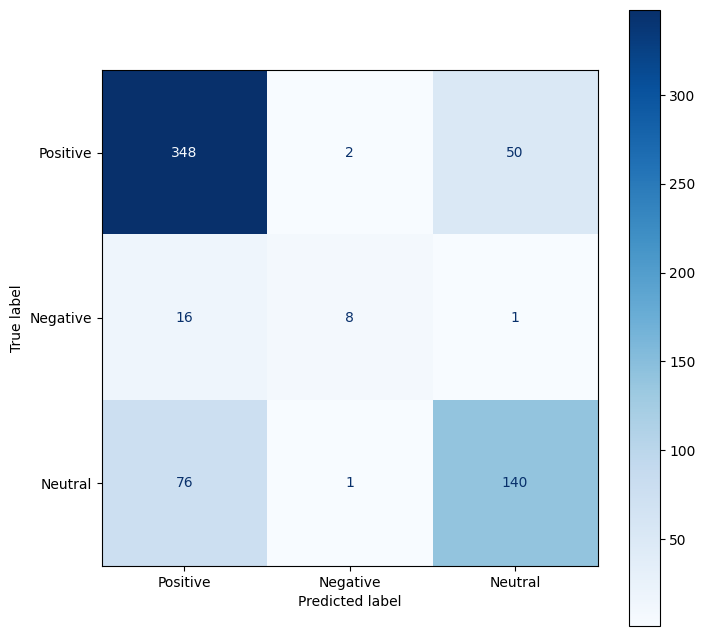

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_predictions(
                  df_test['positions_vac'],
                  bestsplit_preds,
                  labels=[0,1,2],
                  cmap=plt.cm.Blues,
                  display_labels=['Positive','Negative', 'Neutral'],
                  values_format='',
)
fig = disp.ax_.get_figure()
fig.set_figwidth(8)
fig.set_figheight(8)

### Resumo do processo de Treino

In [ ]:
# Resumo do processo de treino

pd.set_option('display.precision', 2)

# Criando um dataframe com nossas estatísticas de treino.

df_stats = pd.DataFrame(data = training_stats)

# Usando cada 'epoch' como índice

df_stats = df_stats.set_index('epoch')

# mostrar a tabela.

df_stats


,Training Loss,Valid. Loss,Valid. Accur.,f1_score_micro,macro_f1_score,weighted_f1_score,classification_report,fold
epoch,,,,,,,,
1,0.64,0.56,0.77,0.77,0.57,0.78,precision recall f1-score sup...,0
2,0.44,0.52,0.79,0.79,0.68,0.80,precision recall f1-score sup...,0
3,0.30,0.57,0.79,0.79,0.71,0.79,precision recall f1-score sup...,0
4,0.18,0.72,0.79,0.79,0.70,0.80,precision recall f1-score sup...,0
5,0.18,0.71,0.78,0.78,0.68,0.78,precision recall f1-score sup...,0
1,0.65,0.53,0.79,0.79,0.63,0.81,precision recall f1-score sup...,1
2,0.45,0.53,0.78,0.78,0.65,0.79,precision recall f1-score sup...,1
3,0.32,0.60,0.77,0.77,0.69,0.78,precision recall f1-score sup...,1
4,0.20,0.73,0.76,0.76,0.68,0.76,precision recall f1-score sup...,1


In [ ]:

df_stats2 = pd.DataFrame(data = training_stats)
df_stats2 = df_stats2.set_index('fold')


df_stats2[df_stats2['epoch'] == 5]

,epoch,Training Loss,Valid. Loss,Valid. Accur.,f1_score_micro,macro_f1_score,weighted_f1_score,classification_report
fold,,,,,,,,
0,5,0.18,0.71,0.78,0.78,0.68,0.78,precision recall f1-score sup...
1,5,0.19,0.63,0.79,0.79,0.69,0.79,precision recall f1-score sup...
2,5,0.20,0.77,0.77,0.77,0.62,0.78,precision recall f1-score sup...
3,5,0.11,0.88,0.78,0.78,0.67,0.79,precision recall f1-score sup...
4,5,0.20,0.59,0.81,0.81,0.72,0.82,precision recall f1-score sup...


In [ ]:
df_stats2[df_stats2['epoch'] == 5].mean()

<ipython-input-51-7c5ffd46eb4c>:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_stats2[df_stats2['epoch'] == 5].mean()


epoch                5.00
Training Loss        0.18
Valid. Loss          0.72
Valid. Accur.        0.78
f1_score_micro       0.78
macro_f1_score       0.68
weighted_f1_score    0.79
dtype: float64

In [ ]:
df_stats[df_stats['fold'] == 0].mean()

<ipython-input-52-199d0543ff22>:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_stats[df_stats['fold'] == 0].mean()


Training Loss        0.35
Valid. Loss          0.62
Valid. Accur.        0.78
f1_score_micro       0.78
macro_f1_score       0.67
weighted_f1_score    0.79
fold                 0.00
dtype: float64

In [ ]:
df_stats.classification_report.iloc[10] # Epoch 3, fold 0

,precision,recall,f1-score,support
0,0.80,0.88,0.84,720.00
1,0.00,0.00,0.00,45.00
2,0.73,0.68,0.71,390.00
accuracy,0.78,0.78,0.78,0.78
macro avg,0.51,0.52,0.52,1155.00
weighted avg,0.75,0.78,0.76,1155.00


In [ ]:
df_fold0 = df_stats[df_stats['fold'] == 0]

df_fold0

,Training Loss,Valid. Loss,Valid. Accur.,f1_score_micro,macro_f1_score,weighted_f1_score,classification_report,fold
epoch,,,,,,,,
1,0.64,0.56,0.77,0.77,0.57,0.78,precision recall f1-score sup...,0
2,0.44,0.52,0.79,0.79,0.68,0.80,precision recall f1-score sup...,0
3,0.30,0.57,0.79,0.79,0.71,0.79,precision recall f1-score sup...,0
4,0.18,0.72,0.79,0.79,0.70,0.80,precision recall f1-score sup...,0
5,0.18,0.71,0.78,0.78,0.68,0.78,precision recall f1-score sup...,0


In [ ]:
df_fold0.classification_report[1] # Isso pega a 1° Epoch

,precision,recall,f1-score,support
0,0.78,0.87,0.82,720.00
1,0.00,0.00,0.00,46.00
2,0.72,0.65,0.68,390.00
accuracy,0.76,0.76,0.76,0.76
macro avg,0.50,0.51,0.50,1156.00
weighted avg,0.73,0.76,0.74,1156.00


In [ ]:
df_fold0.classification_report[1].iloc[[0]] # Métricas da primeira classe na primeira epoch

,precision,recall,f1-score,support
0,0.78,0.87,0.82,720.0


In [ ]:
df_fold0.classification_report[1].iloc[[0]].iloc[:,0] # Primeira métrica (precision) da primeira classe na primeira epoch

0    0.78
Name: precision, dtype: float64

In [ ]:

class0 = []
i = 0
j = 0

for i in range(0,5):
  i += 1
  for j in range(0,5):
    metrics_0 = class0.append({'epoch': j + 1,
                            'fold': i - 1,
                            'precision': float(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[0]].iloc[:,0]),
                            'recall': float(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[0]].iloc[:,1]),
                            'f1-score': float(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[0]].iloc[:,2]),
                            'support': int(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[0]].iloc[:,3])
                            })

    j += 1



class0 = pd.DataFrame(data = class0)

class0




,epoch,fold,precision,recall,f1-score,support
0,1,0,0.78,0.87,0.82,720
1,2,0,0.79,0.89,0.84,720
2,3,0,0.84,0.82,0.83,720
3,4,0,0.81,0.88,0.84,720
4,5,0,0.80,0.87,0.84,720
5,1,1,0.82,0.88,0.85,720
6,2,1,0.84,0.83,0.83,720
7,3,1,0.86,0.79,0.82,720
8,4,1,0.86,0.77,0.81,720
9,5,1,0.83,0.86,0.85,720


In [ ]:
class0.groupby(['fold']).mean()

,epoch,precision,recall,f1-score,support
fold,,,,,
0,3.0,0.80,0.87,0.83,720.0
1,3.0,0.84,0.83,0.83,720.0
2,3.0,0.81,0.87,0.84,720.0
3,3.0,0.81,0.87,0.84,720.0
4,3.0,0.83,0.86,0.84,720.0


In [ ]:
class0[class0['epoch'] == 5]

,epoch,fold,precision,recall,f1-score,support
4,5,0,0.80,0.87,0.84,720
9,5,1,0.83,0.86,0.85,720
14,5,2,0.78,0.89,0.83,720
19,5,3,0.81,0.85,0.83,720
24,5,4,0.81,0.90,0.85,720


In [ ]:
class0[class0['epoch'] == 5].mean()

epoch          5.00
fold           2.00
precision      0.81
recall         0.87
f1-score       0.84
support      720.00
dtype: float64

In [ ]:
class1 = []
i = 0
j = 0

for i in range(0,5):
  i += 1
  for j in range(0,5):
    metrics_0 = class1.append({'epoch': j + 1,
                            'fold': i - 1,
                            'precision': float(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[1]].iloc[:,0]),
                            'recall': float(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[1]].iloc[:,1]),
                            'f1-score': float(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[1]].iloc[:,2]),
                            'support': int(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[1]].iloc[:,3])
                            })

    j += 1



class1 = pd.DataFrame(data = class1)

class1

,epoch,fold,precision,recall,f1-score,support
0,1,0,0.00,0.00,0.00,46
1,2,0,0.72,0.39,0.51,46
2,3,0,0.63,0.57,0.60,46
3,4,0,0.61,0.54,0.57,46
4,5,0,0.55,0.63,0.59,46
5,1,1,0.83,0.11,0.19,46
6,2,1,0.85,0.24,0.37,46
7,3,1,0.83,0.41,0.55,46
8,4,1,0.64,0.46,0.53,46
9,5,1,0.58,0.46,0.51,46


In [ ]:
class1.groupby(['fold']).mean()

,epoch,precision,recall,f1-score,support
fold,,,,,
0,3.0,0.50,0.43,0.45,46.0
1,3.0,0.75,0.33,0.43,46.0
2,3.0,0.60,0.32,0.40,45.0
3,3.0,0.59,0.34,0.43,45.0
4,3.0,0.75,0.39,0.46,45.0


In [ ]:
class1[class1['epoch'] == 5]

,epoch,fold,precision,recall,f1-score,support
4,5,0,0.55,0.63,0.59,46
9,5,1,0.58,0.46,0.51,46
14,5,2,0.73,0.24,0.37,45
19,5,3,0.72,0.47,0.57,45
24,5,4,0.79,0.42,0.55,45


In [ ]:
class1[class1['epoch'] == 5].mean()

epoch         5.00
fold          2.00
precision     0.68
recall        0.44
f1-score      0.52
support      45.40
dtype: float64

In [ ]:
class2 = []
i = 0
j = 0

for i in range(0,5):
  i += 1
  for j in range(0,5):
    metrics_0 = class2.append({'epoch': j + 1,
                            'fold': i - 1,
                            'precision': float(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[2]].iloc[:,0]),
                            'recall': float(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[2]].iloc[:,1]),
                            'f1-score': float(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[2]].iloc[:,2]),
                            'support': int(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[2]].iloc[:,3])
                            })

    j += 1



class2 = pd.DataFrame(data = class2)

class2

,epoch,fold,precision,recall,f1-score,support
0,1,0,0.72,0.65,0.68,390
1,2,0,0.77,0.62,0.69,390
2,3,0,0.70,0.75,0.72,390
3,4,0,0.77,0.66,0.71,390
4,5,0,0.76,0.62,0.68,390
5,1,1,0.75,0.73,0.74,390
6,2,1,0.69,0.76,0.73,390
7,3,1,0.67,0.80,0.73,390
8,4,1,0.65,0.79,0.71,390
9,5,1,0.73,0.71,0.72,390


In [ ]:
class2.groupby(['fold']).mean()

,epoch,precision,recall,f1-score,support
fold,,,,,
0,3.0,0.75,0.66,0.70,390.0
1,3.0,0.70,0.76,0.73,390.0
2,3.0,0.73,0.67,0.70,390.0
3,3.0,0.74,0.67,0.70,390.0
4,3.0,0.75,0.72,0.73,390.0


In [ ]:
class2[class2['epoch'] == 5]

,epoch,fold,precision,recall,f1-score,support
4,5,0,0.76,0.62,0.68,390
9,5,1,0.73,0.71,0.72,390
14,5,2,0.74,0.61,0.67,390
19,5,3,0.71,0.67,0.69,390
24,5,4,0.78,0.67,0.72,390


In [ ]:
class2[class2['epoch'] == 5].mean()

epoch          5.00
fold           2.00
precision      0.74
recall         0.66
f1-score       0.70
support      390.00
dtype: float64

<ipython-input-70-553fcee8258e>:17: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  treino_loss = df_stats.groupby(['epoch']).mean()['Training Loss']
<ipython-input-70-553fcee8258e>:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  valida_loss = df_stats.groupby(['epoch']).mean()['Valid. Loss']


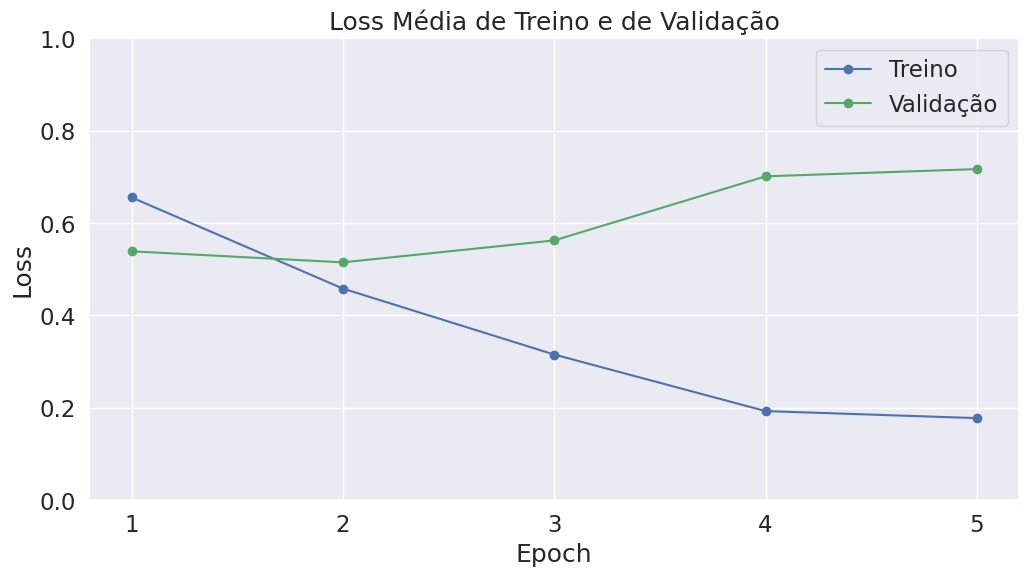

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Plot styling

sns.set(style = "darkgrid")

# Aumenttndo o tamanho do plot e da fonte

sns.set(font_scale = 1.5)
plt.rcParams['figure.figsize'] = (12,6)

# Curva de aprendizado

treino_loss = df_stats.groupby(['epoch']).mean()['Training Loss']
valida_loss = df_stats.groupby(['epoch']).mean()['Valid. Loss']


treino_valid = pd.merge(treino_loss, valida_loss, right_index = True,
               left_index = True)


plt.plot(treino_valid['Training Loss'], 'b-o', label = "Treino")
plt.plot(treino_valid['Valid. Loss'], 'g-o', label = "Validação")

# Labels

plt.title("Loss Média de Treino e de Validação")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1,2,3,4,5])
plt.ylim((0, 1))

plt.show()




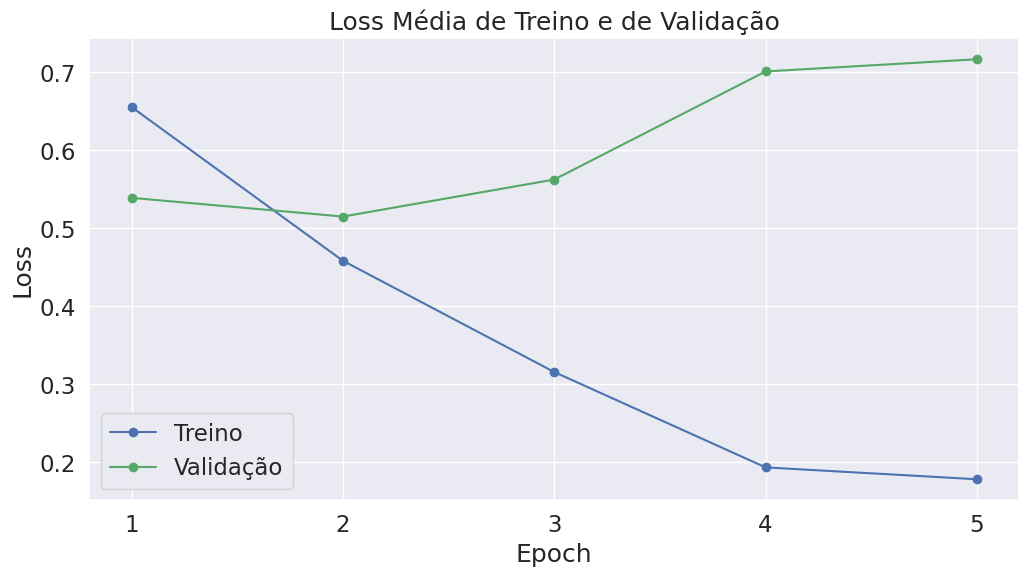

In [ ]:
plt.plot(treino_valid['Training Loss'], 'b-o', label = "Treino")
plt.plot(treino_valid['Valid. Loss'], 'g-o', label = "Validação")

# Labels

plt.title("Loss Média de Treino e de Validação")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1,2,3,4,5])

plt.show()

## Gráficos Classe Positiva (0)

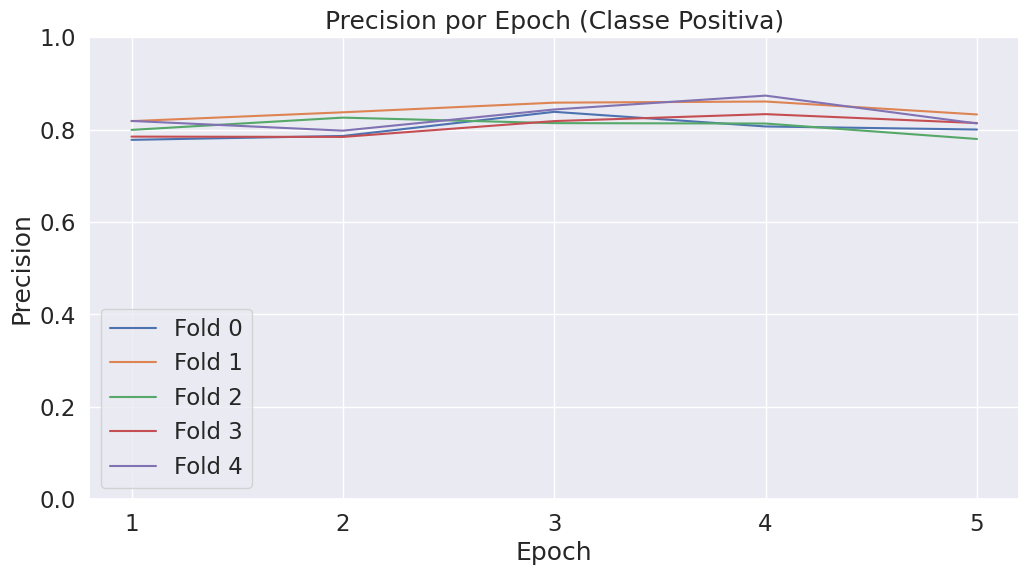

In [ ]:
# Group the dataframe by fold number
grouped = class0.groupby('fold')

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot a line for each fold
for name, group in grouped:
    ax.plot(group['epoch'], group['precision'], label=f"Fold {name}")

# Add a legend to the plot
ax.legend()

# Add labels to the x and y axis
ax.set_xlabel('Epoch')
ax.set_ylabel('Precision')

plt.title("Precision por Epoch (Classe Positiva)")

plt.xticks([1,2,3,4,5])
plt.ylim((0, 1))

# Show the plot
plt.show()

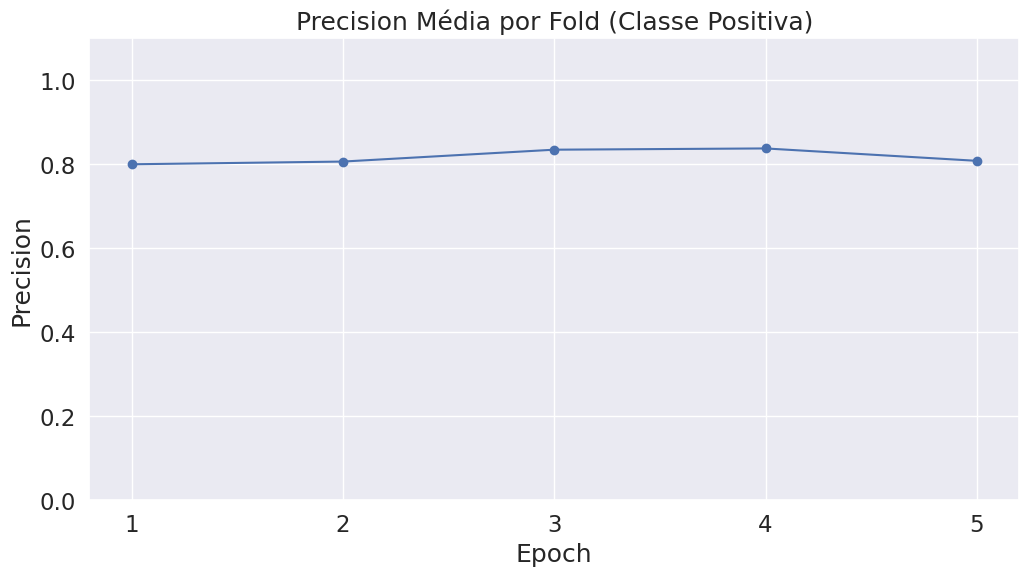

In [ ]:
# Group the dataframe by fold number
grouped = class0.groupby('epoch').mean()

plt.plot(grouped['precision'], 'b-o')

# Labels

plt.title("Precision Média por Fold (Classe Positiva)")
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.xticks([1,2,3,4,5])
plt.ylim((0, 1.1))

plt.show()

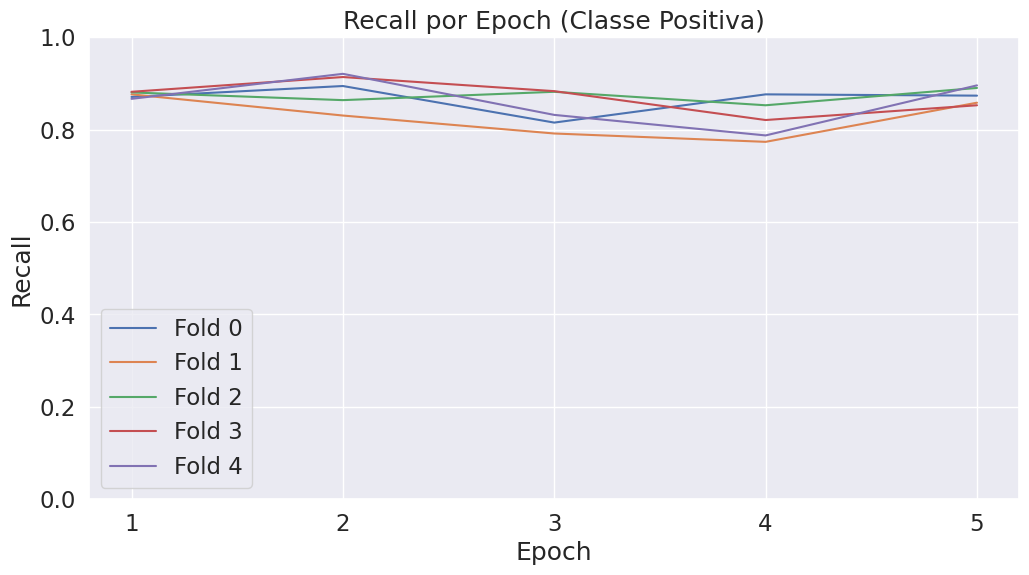

In [ ]:
# Group the dataframe by fold number
grouped = class0.groupby('fold')

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot a line for each fold
for name, group in grouped:
    ax.plot(group['epoch'], group['recall'], label=f"Fold {name}")

# Add a legend to the plot
ax.legend()

# Add labels to the x and y axis
ax.set_xlabel('Epoch')
ax.set_ylabel('Recall')

plt.title("Recall por Epoch (Classe Positiva)")

plt.xticks([1,2,3,4,5])
plt.ylim((0, 1))

# Show the plot
plt.show()

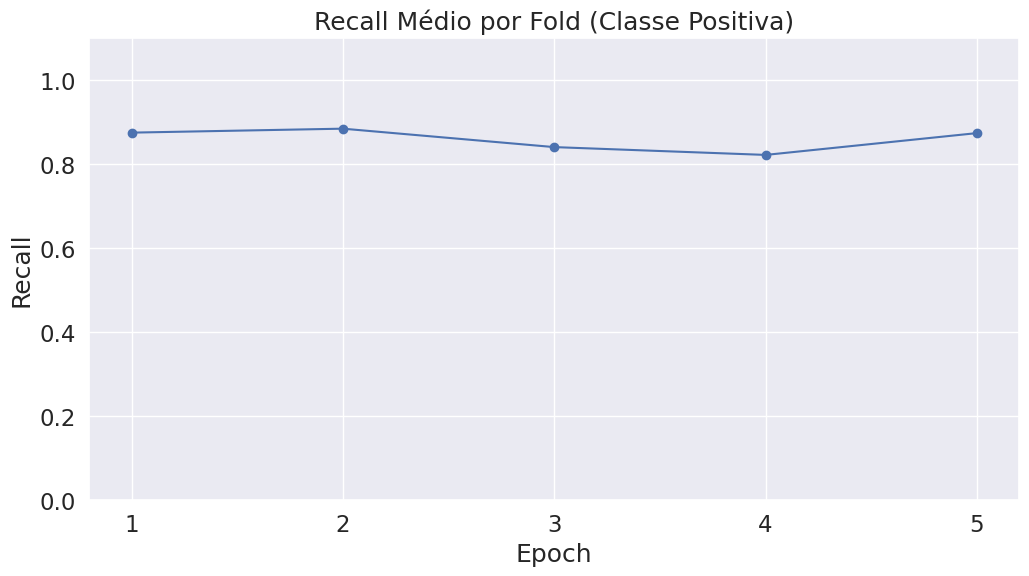

In [ ]:
# Group the dataframe by fold number
grouped = class0.groupby('epoch').mean()

plt.plot(grouped['recall'], 'b-o')

# Labels

plt.title("Recall Médio por Fold (Classe Positiva)")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.xticks([1,2,3,4,5])
plt.ylim((0, 1.1))

plt.show()

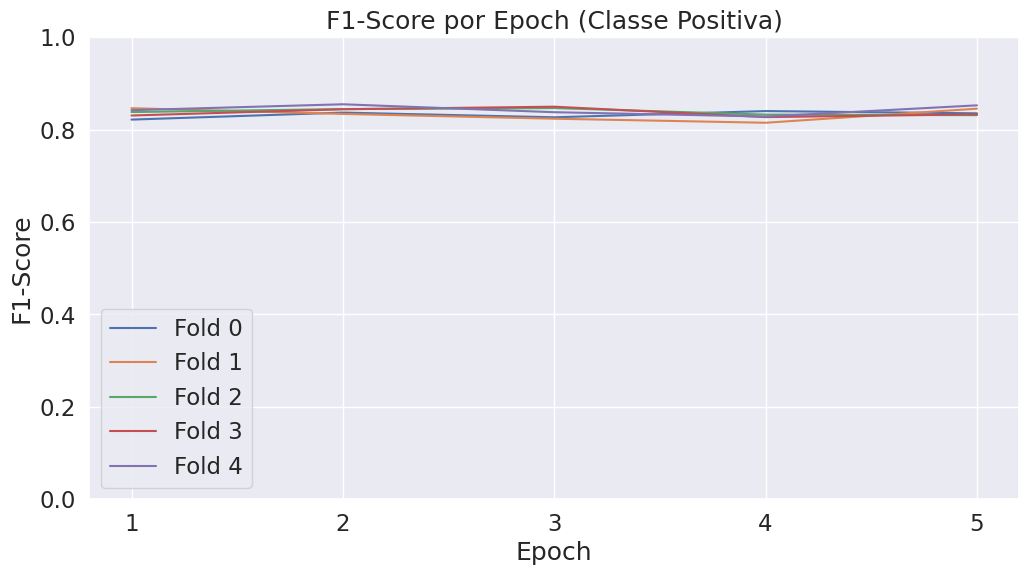

In [ ]:
# Group the dataframe by fold number
grouped = class0.groupby('fold')

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot a line for each fold
for name, group in grouped:
    ax.plot(group['epoch'], group['f1-score'], label=f"Fold {name}")

# Add a legend to the plot
ax.legend()

# Add labels to the x and y axis
ax.set_xlabel('Epoch')
ax.set_ylabel('F1-Score')

plt.title("F1-Score por Epoch (Classe Positiva)")

plt.xticks([1,2,3,4,5])
plt.ylim((0, 1))

# Show the plot
plt.show()

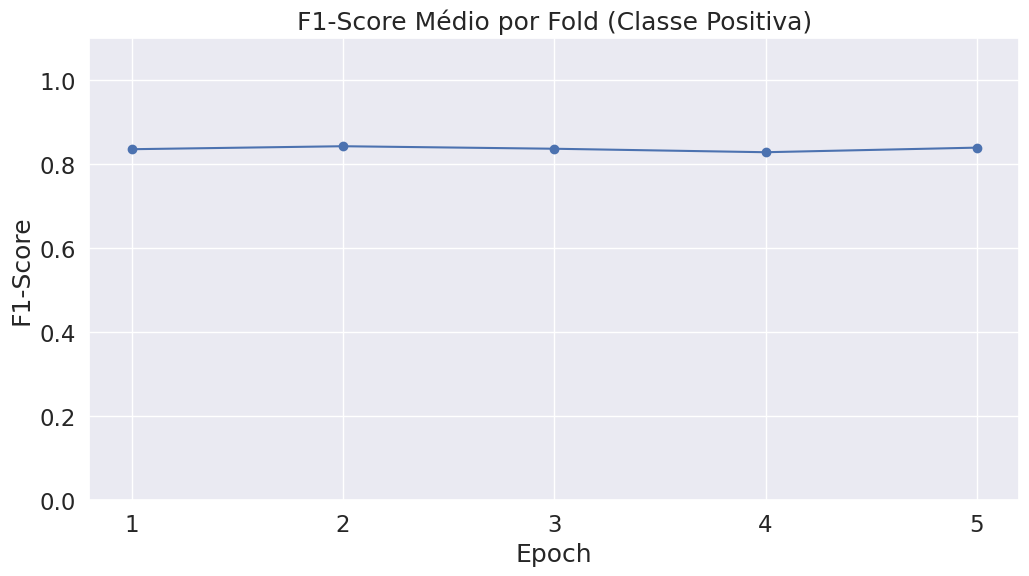

In [ ]:
# Group the dataframe by fold number
grouped = class0.groupby('epoch').mean()

plt.plot(grouped['f1-score'], 'b-o')

# Labels

plt.title("F1-Score Médio por Fold (Classe Positiva)")
plt.xlabel("Epoch")
plt.ylabel("F1-Score")
plt.xticks([1,2,3,4,5])
plt.ylim((0, 1.1))

plt.show()

## Gráficos Classe Negativa

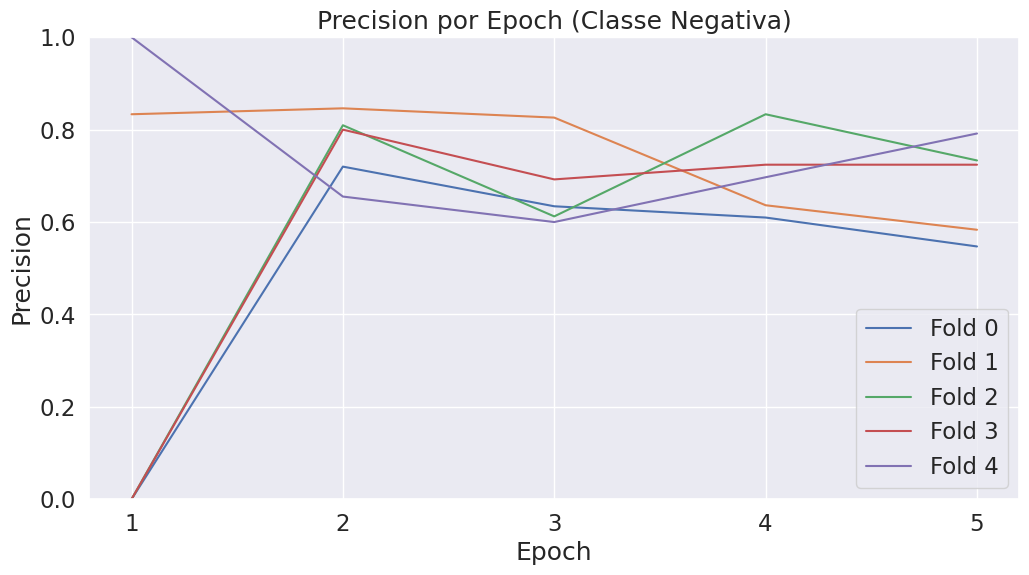

In [ ]:
# Group the dataframe by fold number
grouped = class1.groupby('fold')

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot a line for each fold
for name, group in grouped:
    ax.plot(group['epoch'], group['precision'], label=f"Fold {name}")

# Add a legend to the plot
ax.legend()

# Add labels to the x and y axis
ax.set_xlabel('Epoch')
ax.set_ylabel('Precision')

plt.title("Precision por Epoch (Classe Negativa)")

plt.xticks([1,2,3,4,5])
plt.ylim((0, 1))

# Show the plot
plt.show()

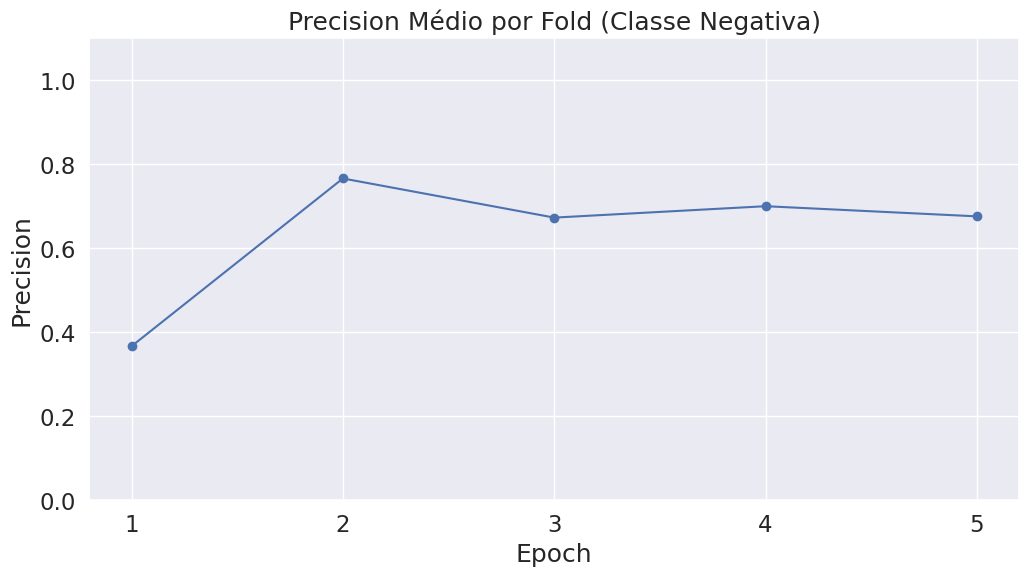

In [ ]:
# Group the dataframe by fold number
grouped = class1.groupby('epoch').mean()

plt.plot(grouped['precision'], 'b-o')

# Labels

plt.title("Precision Médio por Fold (Classe Negativa)")
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.xticks([1,2,3,4,5])
plt.ylim((0, 1.1))

plt.show()

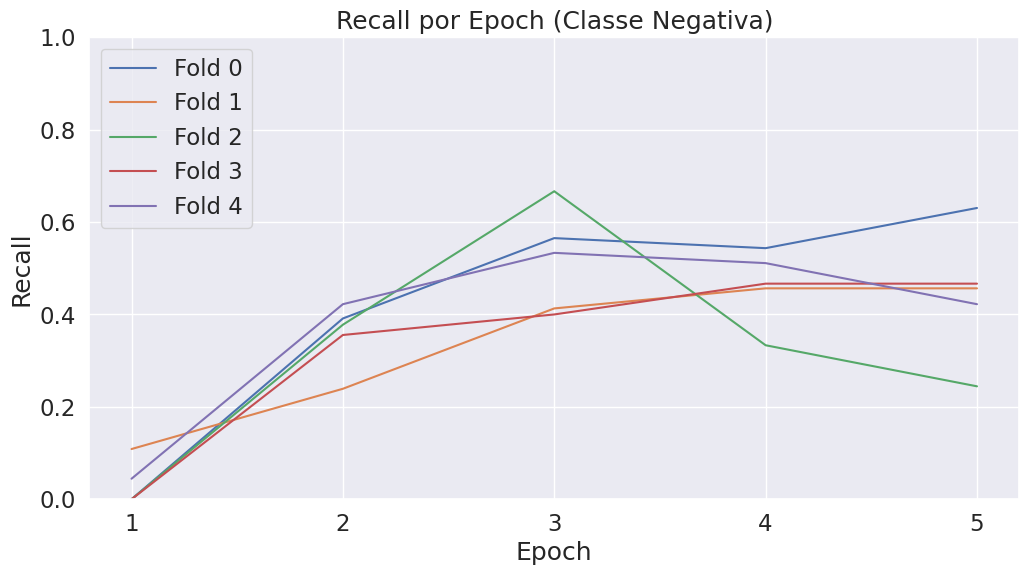

In [ ]:
# Group the dataframe by fold number
grouped = class1.groupby('fold')

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot a line for each fold
for name, group in grouped:
    ax.plot(group['epoch'], group['recall'], label=f"Fold {name}")

# Add a legend to the plot
ax.legend()

# Add labels to the x and y axis
ax.set_xlabel('Epoch')
ax.set_ylabel('Recall')

plt.title("Recall por Epoch (Classe Negativa)")

plt.xticks([1,2,3,4,5])
plt.ylim((0, 1))

# Show the plot
plt.show()

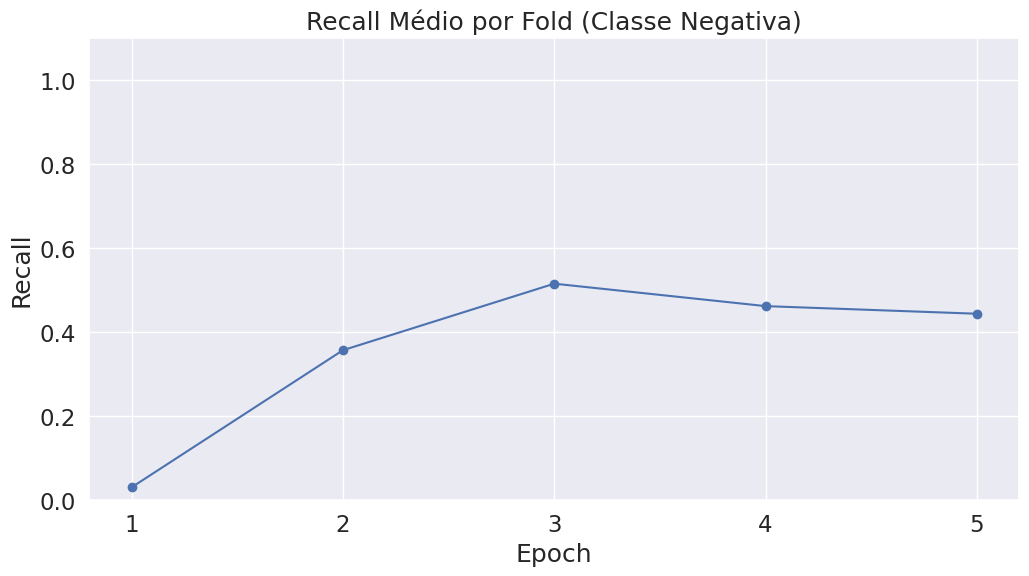

In [ ]:
# Group the dataframe by fold number
grouped = class1.groupby('epoch').mean()

plt.plot(grouped['recall'], 'b-o')

# Labels

plt.title("Recall Médio por Fold (Classe Negativa)")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.xticks([1,2,3,4,5])
plt.ylim((0, 1.1))

plt.show()

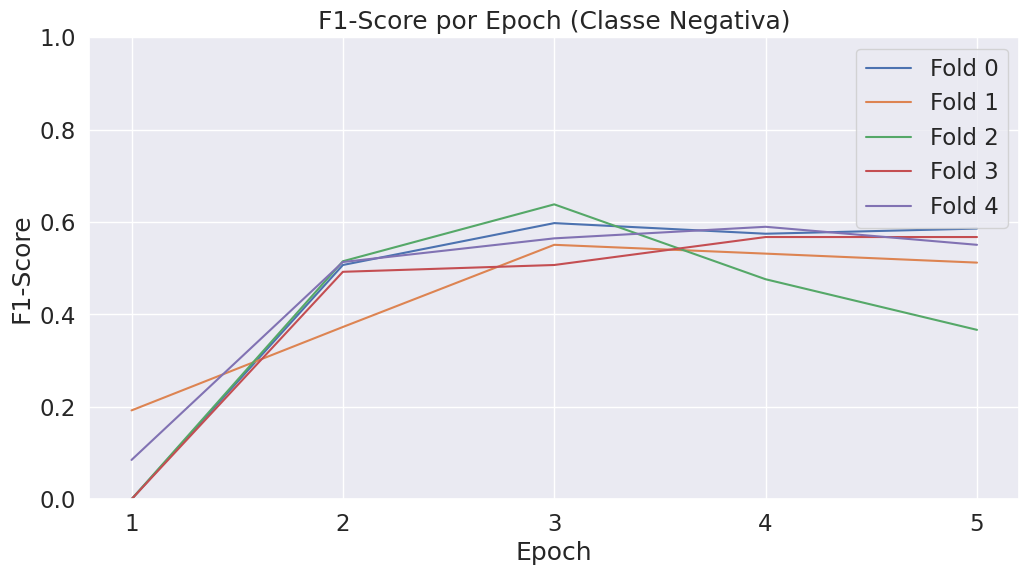

In [ ]:
# Group the dataframe by fold number
grouped = class1.groupby('fold')

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot a line for each fold
for name, group in grouped:
    ax.plot(group['epoch'], group['f1-score'], label=f"Fold {name}")

# Add a legend to the plot
ax.legend()

# Add labels to the x and y axis
ax.set_xlabel('Epoch')
ax.set_ylabel('F1-Score')

plt.title("F1-Score por Epoch (Classe Negativa)")

plt.xticks([1,2,3,4,5])
plt.ylim((0, 1))

# Show the plot
plt.show()

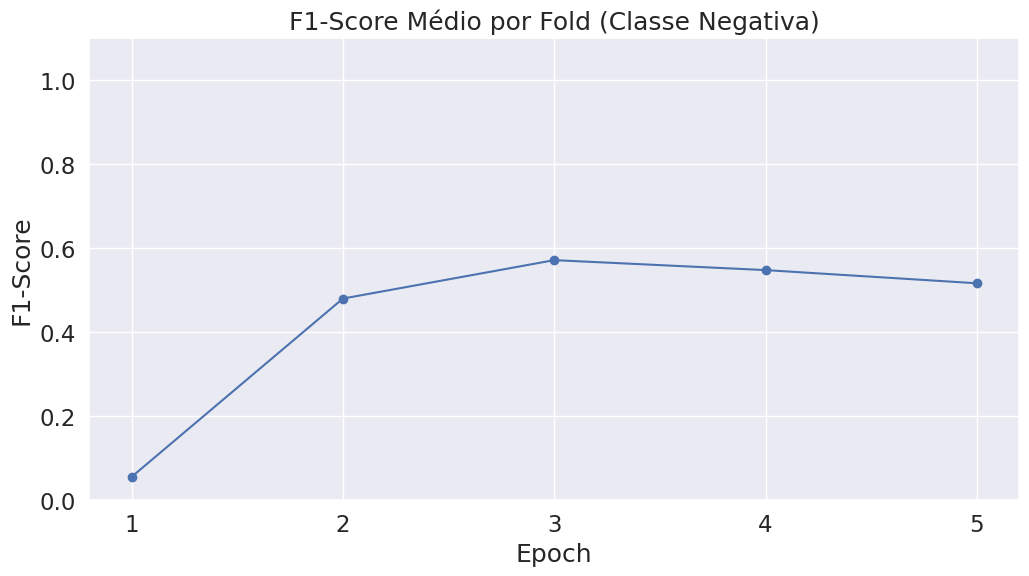

In [ ]:
# Group the dataframe by fold number
grouped = class1.groupby('epoch').mean()

plt.plot(grouped['f1-score'], 'b-o')

# Labels

plt.title("F1-Score Médio por Fold (Classe Negativa)")
plt.xlabel("Epoch")
plt.ylabel("F1-Score")
plt.xticks([1,2,3,4,5])
plt.ylim((0, 1.1))

plt.show()

## Classe Neutra

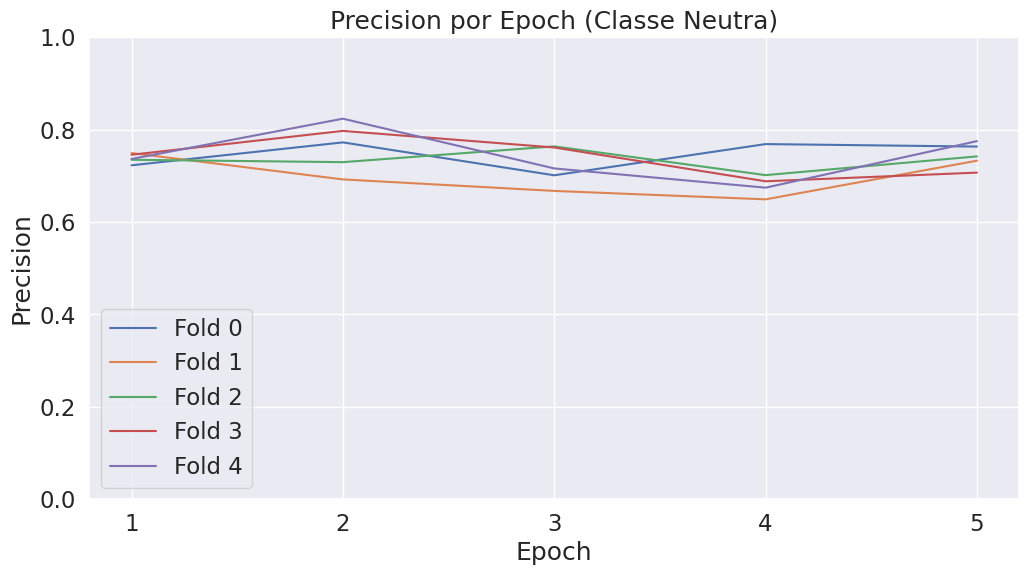

In [ ]:
# Group the dataframe by fold number
grouped = class2.groupby('fold')

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot a line for each fold
for name, group in grouped:
    ax.plot(group['epoch'], group['precision'], label=f"Fold {name}")

# Add a legend to the plot
ax.legend()

# Add labels to the x and y axis
ax.set_xlabel('Epoch')
ax.set_ylabel('Precision')

plt.title("Precision por Epoch (Classe Neutra)")

plt.xticks([1,2,3,4,5])
plt.ylim((0, 1))

# Show the plot
plt.show()

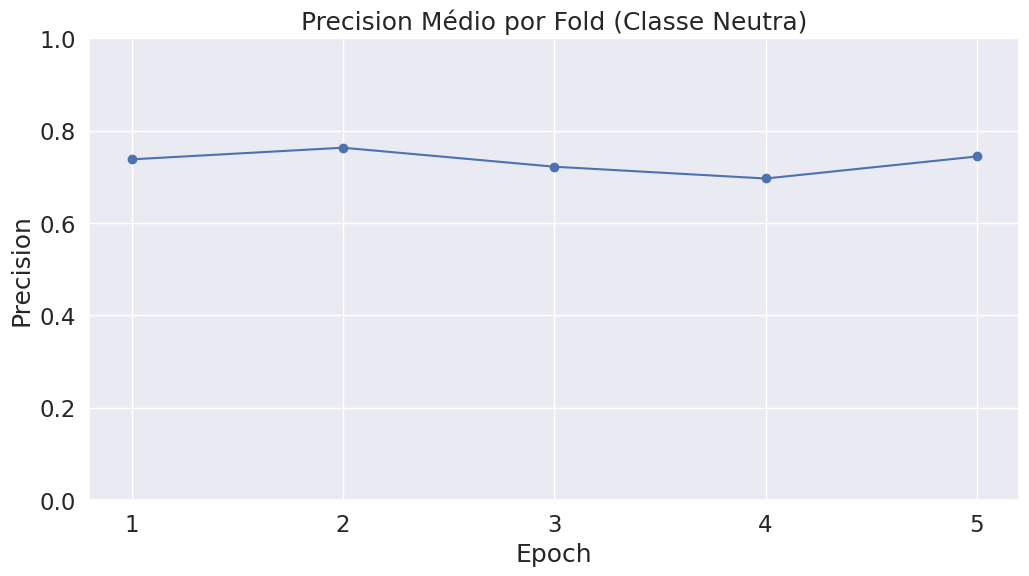

In [ ]:
# Group the dataframe by fold number
grouped = class2.groupby('epoch').mean()

plt.plot(grouped['precision'], 'b-o')

# Labels

plt.title("Precision Médio por Fold (Classe Neutra)")
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.xticks([1,2,3,4,5])
plt.ylim((0, 1))

plt.show()

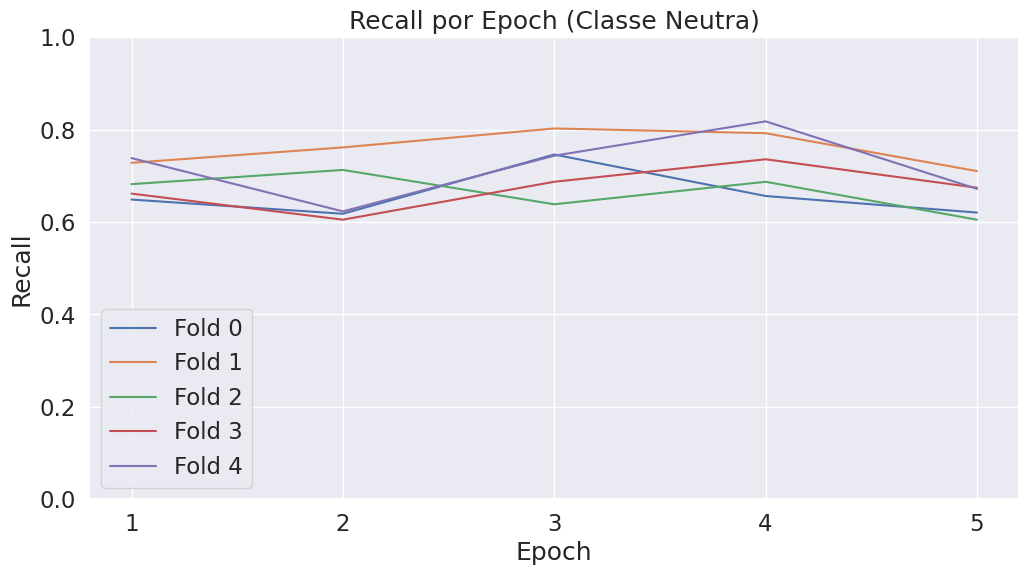

In [ ]:
# Group the dataframe by fold number
grouped = class2.groupby('fold')

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot a line for each fold
for name, group in grouped:
    ax.plot(group['epoch'], group['recall'], label=f"Fold {name}")

# Add a legend to the plot
ax.legend()

# Add labels to the x and y axis
ax.set_xlabel('Epoch')
ax.set_ylabel('Recall')

plt.title("Recall por Epoch (Classe Neutra)")

plt.xticks([1,2,3,4,5])
plt.ylim((0, 1))

# Show the plot
plt.show()

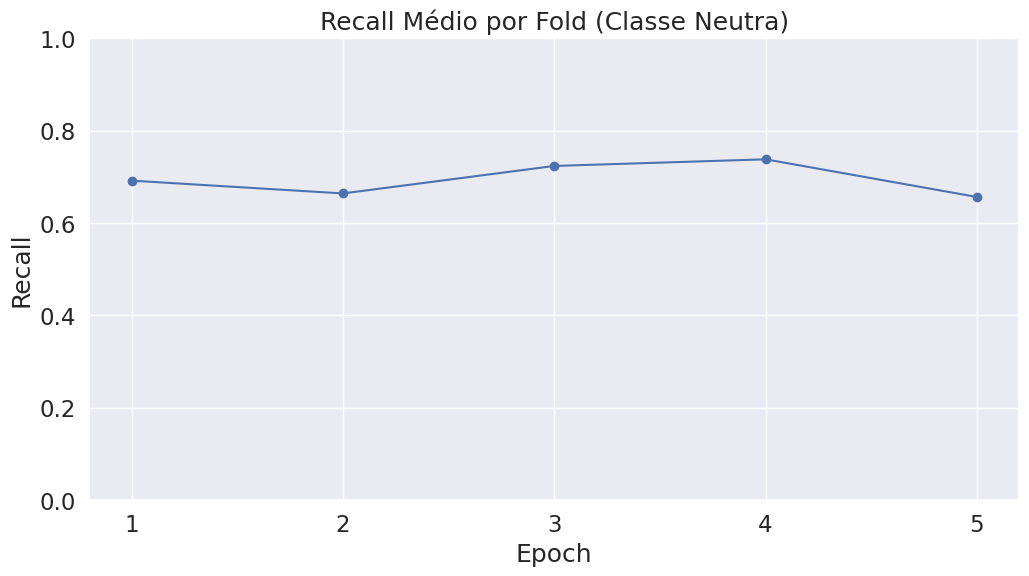

In [ ]:
# Group the dataframe by fold number
grouped = class2.groupby('epoch').mean()

plt.plot(grouped['recall'], 'b-o')

# Labels

plt.title("Recall Médio por Fold (Classe Neutra)")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.xticks([1,2,3,4,5])
plt.ylim((0, 1))

plt.show()

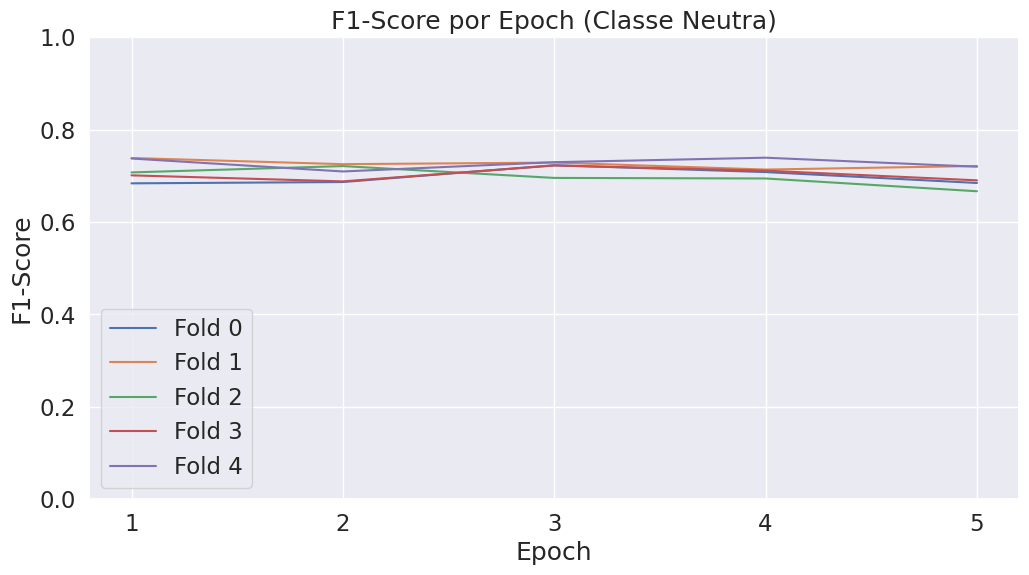

In [ ]:
# Group the dataframe by fold number
grouped = class2.groupby('fold')

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot a line for each fold
for name, group in grouped:
    ax.plot(group['epoch'], group['f1-score'], label=f"Fold {name}")

# Add a legend to the plot
ax.legend()

# Add labels to the x and y axis
ax.set_xlabel('Epoch')
ax.set_ylabel('F1-Score')

plt.title("F1-Score por Epoch (Classe Neutra)")

plt.xticks([1,2,3,4,5])
plt.ylim((0, 1))

# Show the plot
plt.show()

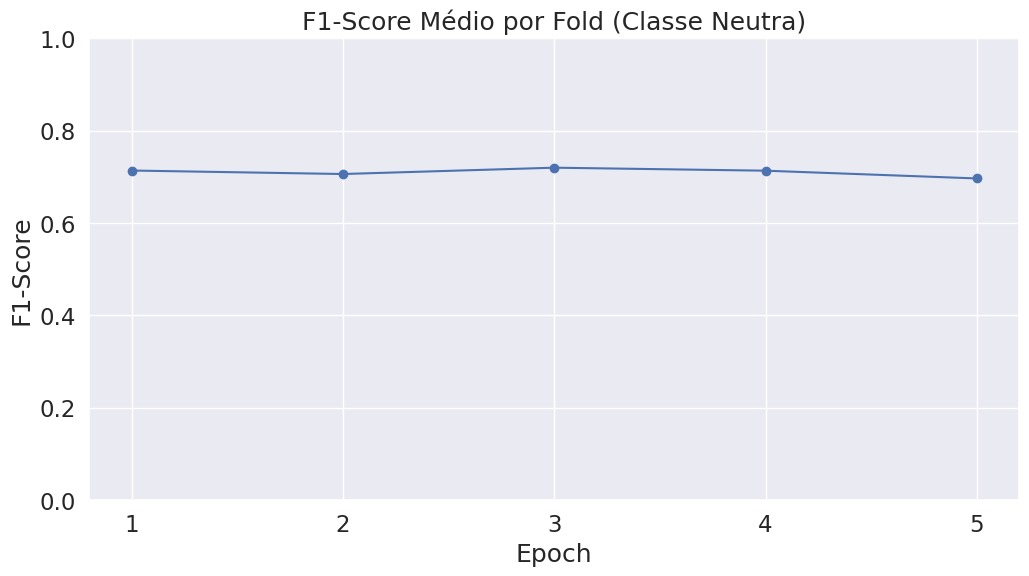

In [ ]:
# Group the dataframe by fold number
grouped = class2.groupby('epoch').mean()

plt.plot(grouped['f1-score'], 'b-o')

# Labels

plt.title("F1-Score Médio por Fold (Classe Neutra)")
plt.xlabel("Epoch")
plt.ylabel("F1-Score")
plt.xticks([1,2,3,4,5])
plt.ylim((0, 1))

plt.show()

### Criando Figuras para o Artigo


#### Average Precision for Each Class

In [ ]:
grouped0 = class0.groupby('epoch').mean()
grouped1 = class1.groupby('epoch').mean()
grouped2 = class2.groupby('epoch').mean()

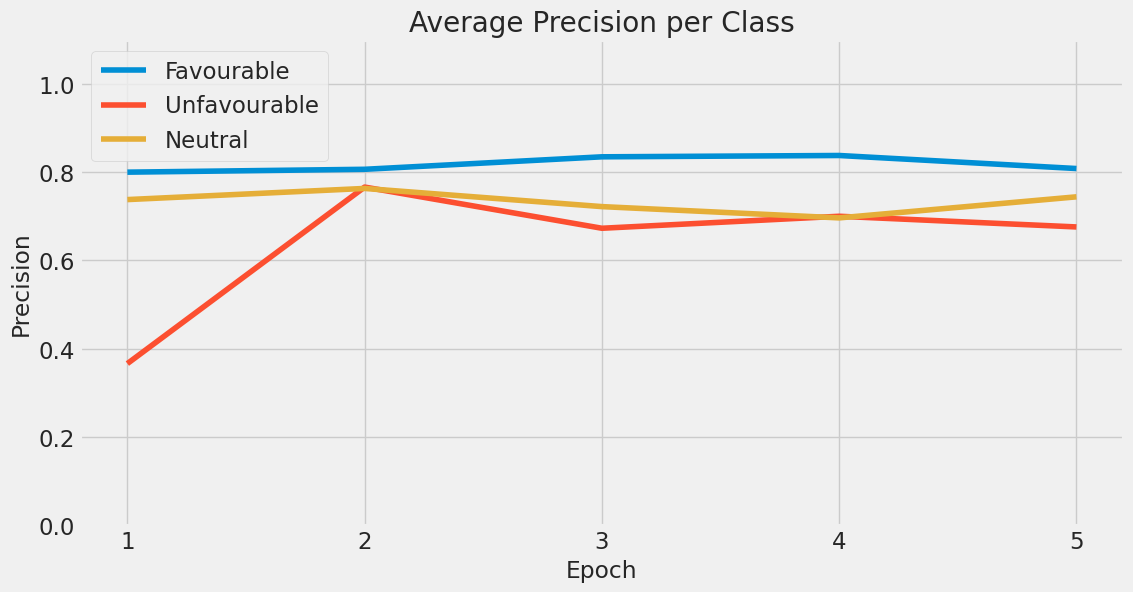

<Figure size 1200x600 with 0 Axes>

In [ ]:
# Set the style to a minimalist theme
plt.style.use('fivethirtyeight')

plt.plot(grouped0['precision'], label = "Favourable")
plt.plot(grouped1['precision'], label = "Unfavourable")
plt.plot(grouped2['precision'], label = "Neutral")


# Labels

plt.title("Average Precision per Class")
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.xticks([1,2,3,4,5])
plt.ylim((0, 1.1))
plt.legend()

plt.show()

plt.savefig('/content/drive/MyDrive/Projeto Posicionamento COVID/images/2020+21avgprecisionclass.eps', format='eps', transparent = True, bbox_inches='tight')

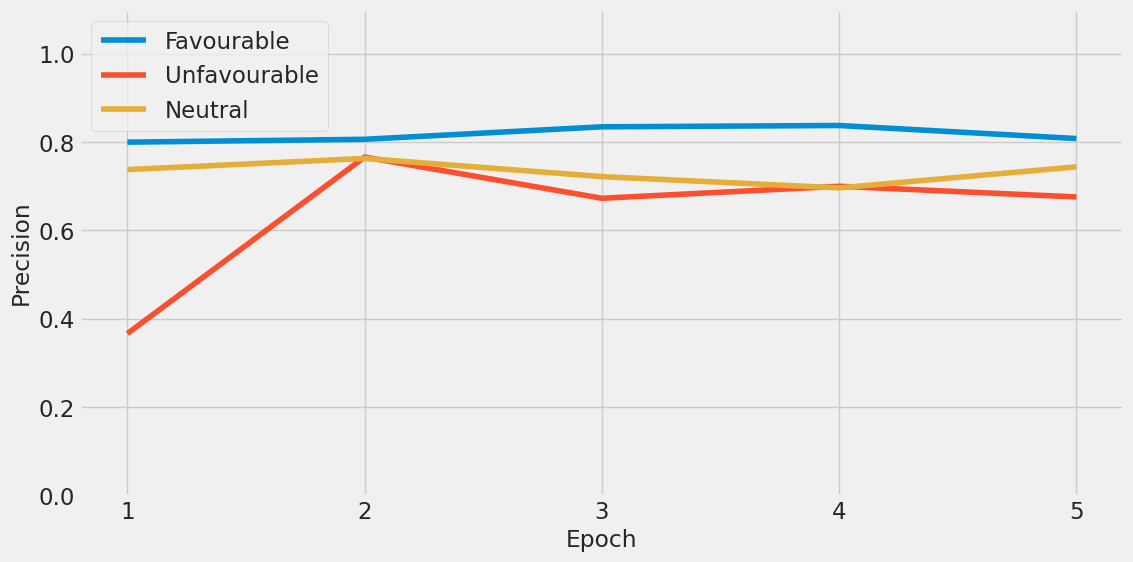

In [ ]:
# Set the style to a minimalist theme
plt.style.use('fivethirtyeight')

plt.plot(grouped0['precision'], label = "Favourable")
plt.plot(grouped1['precision'], label = "Unfavourable")
plt.plot(grouped2['precision'], label = "Neutral")


# Labels

plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.xticks([1,2,3,4,5])
plt.ylim((0, 1.1))
plt.legend()

plt.savefig('/content/drive/MyDrive/Projeto Posicionamento COVID/images/2020+21avgprecisionclassnoleg.eps', format='eps', transparent = True, bbox_inches='tight')

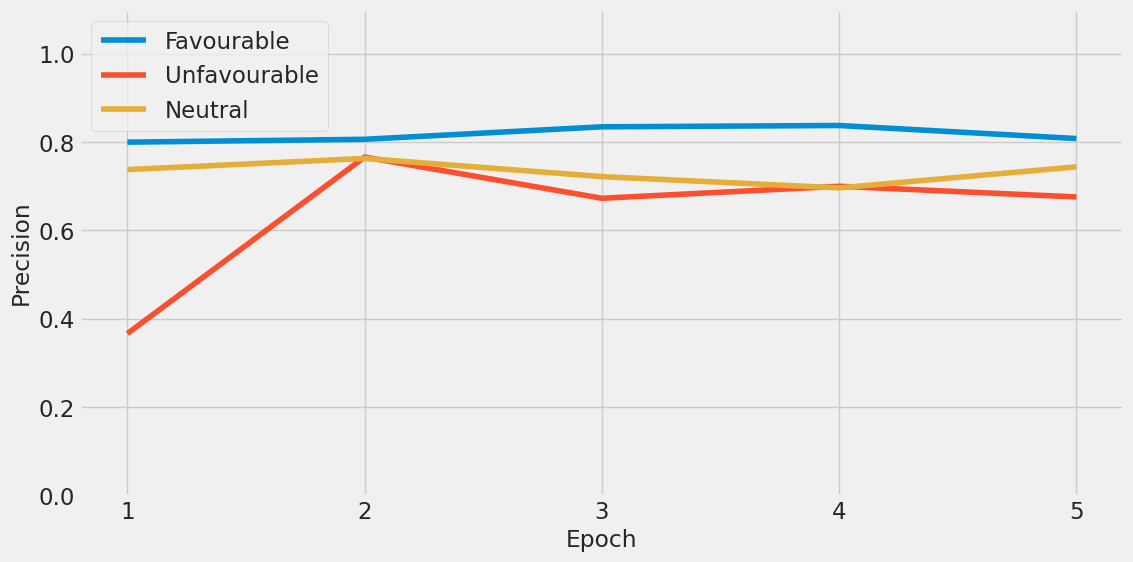

In [ ]:
# Set the style to a minimalist theme
plt.style.use('fivethirtyeight')

plt.plot(grouped0['precision'], label = "Favourable")
plt.plot(grouped1['precision'], label = "Unfavourable")
plt.plot(grouped2['precision'], label = "Neutral")


# Labels

plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.xticks([1,2,3,4,5])
plt.ylim((0, 1.1))
plt.legend()

plt.savefig('/content/drive/MyDrive/Projeto Posicionamento COVID/images/2020+21avgprecisionclassnoleg.png', format='png', transparent = True, bbox_inches='tight')

#### Recall

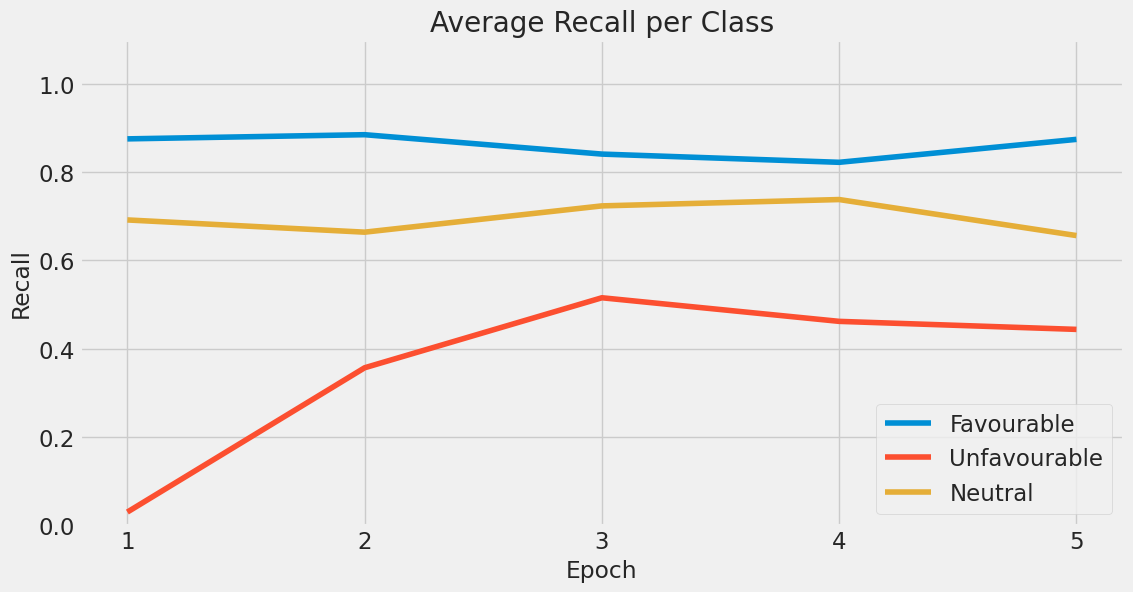

In [ ]:
# Set the style to a minimalist theme
plt.style.use('fivethirtyeight')

plt.plot(grouped0['recall'], label = "Favourable")
plt.plot(grouped1['recall'], label = "Unfavourable")
plt.plot(grouped2['recall'], label = "Neutral")


# Labels

plt.title("Average Recall per Class")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.xticks([1,2,3,4,5])
plt.ylim((0, 1.1))
plt.legend()


plt.savefig('/content/drive/MyDrive/Projeto Posicionamento COVID/images/2020+21avgrecallclass.eps', format='eps', transparent = True, bbox_inches='tight')

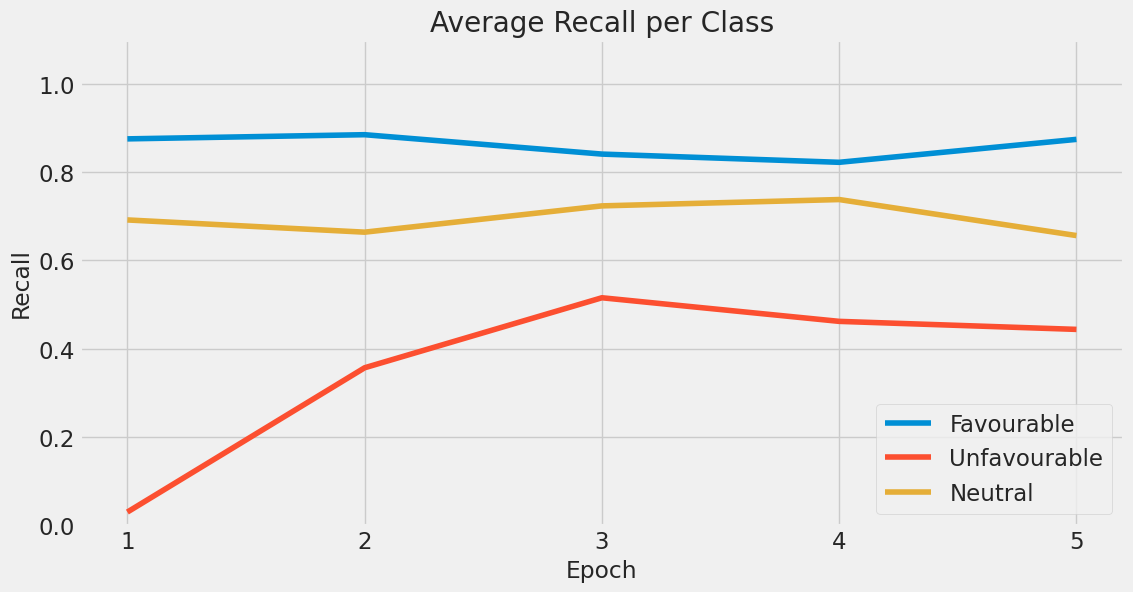

In [ ]:
# Set the style to a minimalist theme
plt.style.use('fivethirtyeight')

plt.plot(grouped0['recall'], label = "Favourable")
plt.plot(grouped1['recall'], label = "Unfavourable")
plt.plot(grouped2['recall'], label = "Neutral")


# Labels

plt.title("Average Recall per Class")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.xticks([1,2,3,4,5])
plt.ylim((0, 1.1))
plt.legend()


plt.savefig('/content/drive/MyDrive/Projeto Posicionamento COVID/images/2020+21avgrecallclass.png', format='png', transparent = True, bbox_inches='tight')

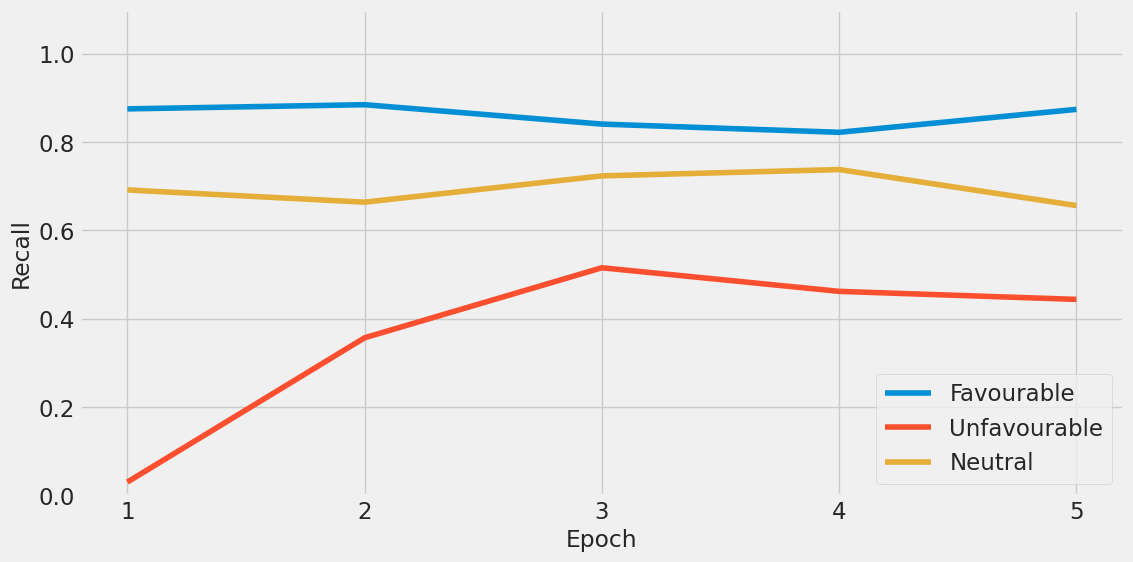

In [ ]:
# Set the style to a minimalist theme
plt.style.use('fivethirtyeight')

plt.plot(grouped0['recall'], label = "Favourable")
plt.plot(grouped1['recall'], label = "Unfavourable")
plt.plot(grouped2['recall'], label = "Neutral")


# Labels

plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.xticks([1,2,3,4,5])
plt.ylim((0, 1.1))
plt.legend()


plt.savefig('/content/drive/MyDrive/Projeto Posicionamento COVID/images/2020+21avgrecallclassnoleg.eps', format='eps', transparent = True, bbox_inches='tight')

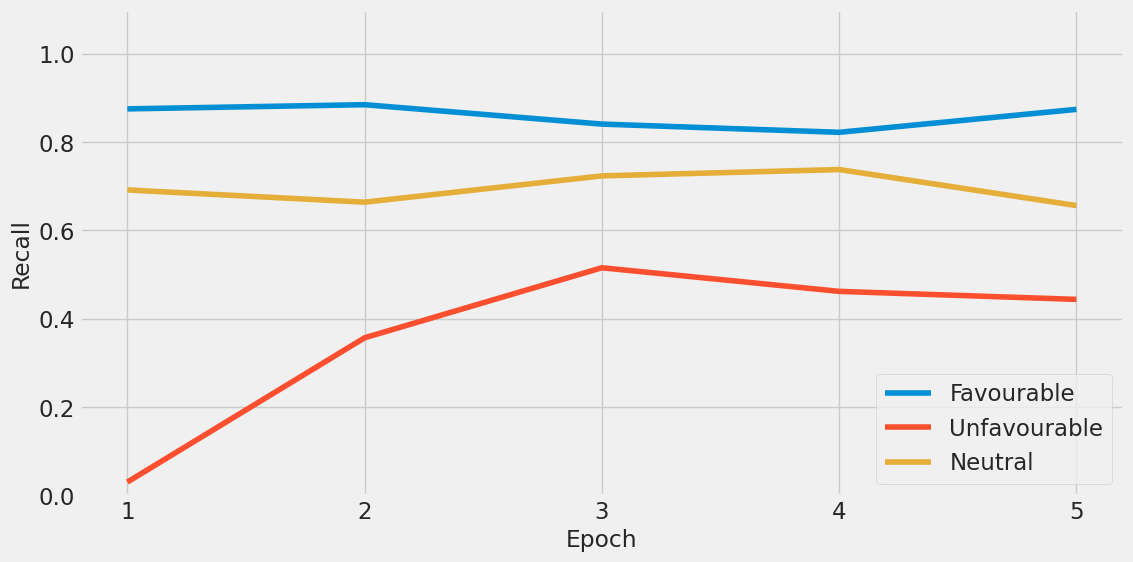

In [ ]:
# Set the style to a minimalist theme
plt.style.use('fivethirtyeight')

plt.plot(grouped0['recall'], label = "Favourable")
plt.plot(grouped1['recall'], label = "Unfavourable")
plt.plot(grouped2['recall'], label = "Neutral")


# Labels

plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.xticks([1,2,3,4,5])
plt.ylim((0, 1.1))
plt.legend()



plt.savefig('/content/drive/MyDrive/Projeto Posicionamento COVID/images/2020+21avgrecallclassnoleg.png', format='png', transparent = True, bbox_inches='tight')

#### F1-score

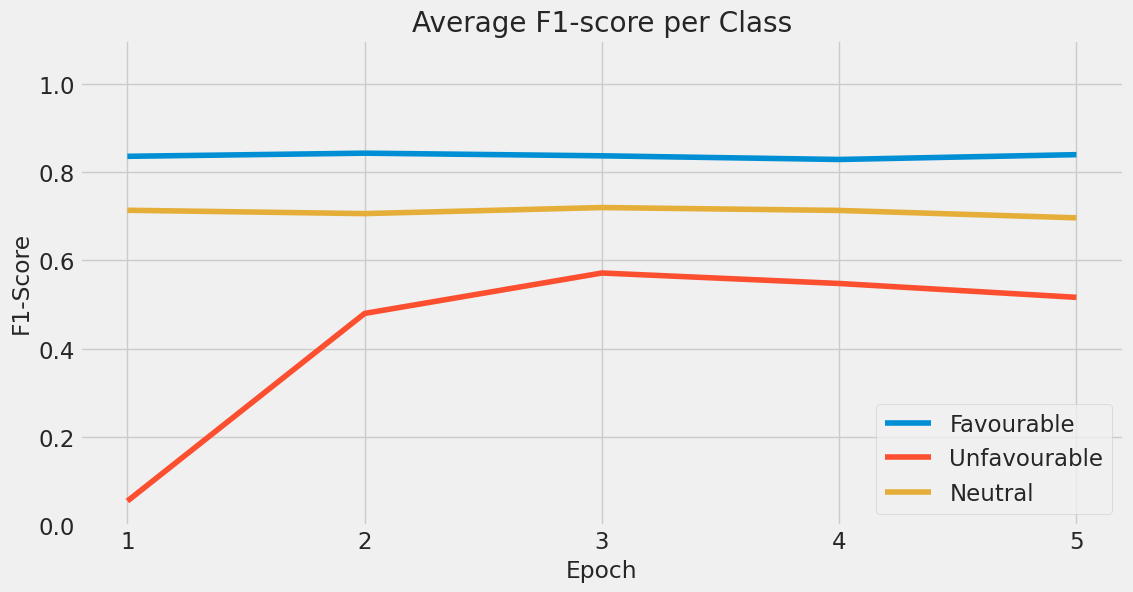

In [ ]:
# Set the style to a minimalist theme
plt.style.use('fivethirtyeight')

plt.plot(grouped0['f1-score'], label = "Favourable")
plt.plot(grouped1['f1-score'], label = "Unfavourable")
plt.plot(grouped2['f1-score'], label = "Neutral")


# Labels

plt.title("Average F1-score per Class")
plt.xlabel("Epoch")
plt.ylabel("F1-Score")
plt.xticks([1,2,3,4,5])
plt.ylim((0, 1.1))
plt.legend()


plt.savefig('/content/drive/MyDrive/Projeto Posicionamento COVID/images/2020+21avgf1class.eps', format='eps', transparent = True, bbox_inches='tight')

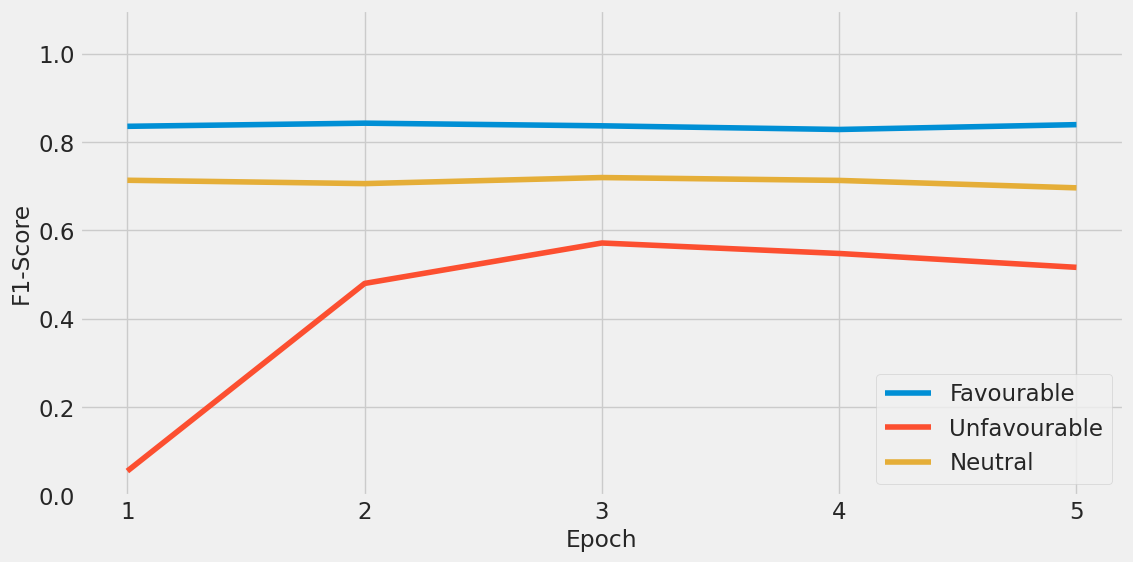

In [ ]:
# Set the style to a minimalist theme
plt.style.use('fivethirtyeight')

plt.plot(grouped0['f1-score'], label = "Favourable")
plt.plot(grouped1['f1-score'], label = "Unfavourable")
plt.plot(grouped2['f1-score'], label = "Neutral")


# Labels

plt.xlabel("Epoch")
plt.ylabel("F1-Score")
plt.xticks([1,2,3,4,5])
plt.ylim((0, 1.1))
plt.legend()



plt.savefig('/content/drive/MyDrive/Projeto Posicionamento COVID/images/2020+21avgf1classnoleg.eps', format='eps', transparent = True, bbox_inches='tight')

#### Loss

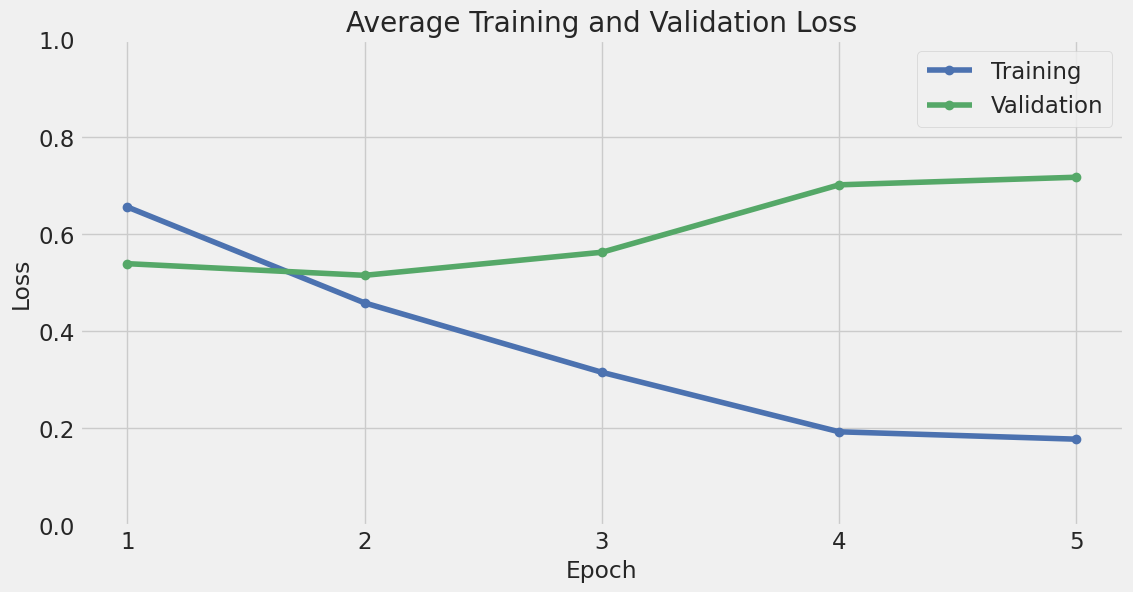

In [ ]:
plt.plot(treino_valid['Training Loss'], 'b-o', label = "Training")
plt.plot(treino_valid['Valid. Loss'], 'g-o', label = "Validation")

# Labels

plt.title("Average Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1,2,3,4,5])
plt.ylim((0, 1))



plt.savefig('/content/drive/MyDrive/Projeto Posicionamento COVID/images/2020+21avgloss.eps', format='eps', transparent = True, bbox_inches='tight')

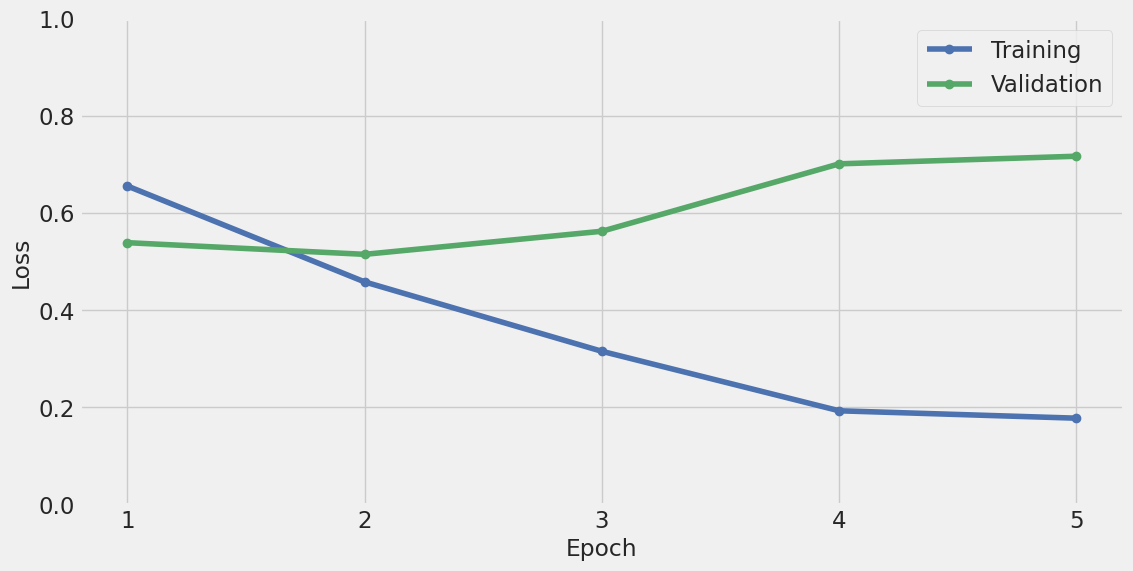

In [ ]:
plt.plot(treino_valid['Training Loss'], 'b-o', label = "Training")
plt.plot(treino_valid['Valid. Loss'], 'g-o', label = "Validation")

# Labels

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1,2,3,4,5])
plt.ylim((0, 1))




plt.savefig('/content/drive/MyDrive/Projeto Posicionamento COVID/images/2020+21avglossnoleg.eps', format='eps', transparent = True, bbox_inches='tight')

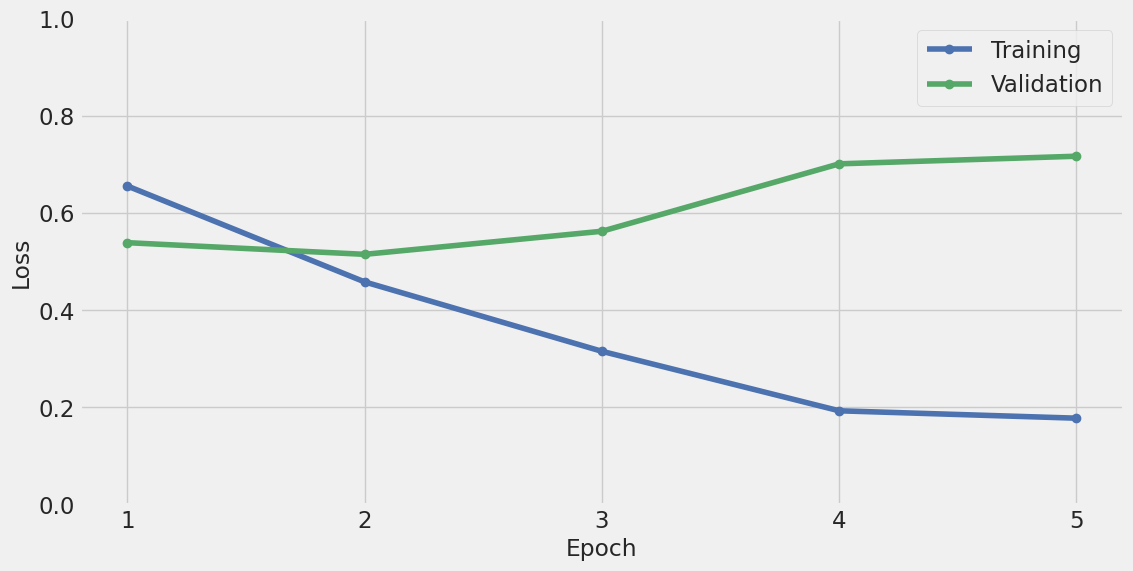

In [ ]:
plt.plot(treino_valid['Training Loss'], 'b-o', label = "Training")
plt.plot(treino_valid['Valid. Loss'], 'g-o', label = "Validation")

# Labels

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1,2,3,4,5])
plt.ylim((0, 1))




plt.savefig('/content/drive/MyDrive/Projeto Posicionamento COVID/images/2020+21avglossnoleg.png', format='png', transparent = True, bbox_inches='tight')

## Salvando o modelo

In [ ]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = '/content/drive/MyDrive/Projeto Posicionamento COVID/modelos/BERT+KFold(2020-21)'

# criar diretório de resultado se preciso
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Salvando o modelo em %s" % output_dir)


# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`

model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)


Salvando o modelo em /content/drive/MyDrive/Projeto Posicionamento COVID/modelos/BERT+KFold(2020-21)


('/content/drive/MyDrive/Projeto Posicionamento COVID/modelos/BERT+KFold(2020-21)/tokenizer_config.json',
 '/content/drive/MyDrive/Projeto Posicionamento COVID/modelos/BERT+KFold(2020-21)/special_tokens_map.json',
 '/content/drive/MyDrive/Projeto Posicionamento COVID/modelos/BERT+KFold(2020-21)/vocab.txt',
 '/content/drive/MyDrive/Projeto Posicionamento COVID/modelos/BERT+KFold(2020-21)/added_tokens.json')

In [ ]:
# Para carregar o modelo direto do disco

model = BertForSequenceClassification.from_pretrained(output_dir)
tokenizer = BertTokenizer.from_pretrained(output_dir)

# Copy the model to the GPU

model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,